# [무역통계생팀] 고객 세분화 분류 분석 

**팀원 : minuwoo, yejinLee, 강민송, SoominB**

---
### 목차
#### 1. 고객 세분화 방법
    - import, read data
    - 변수설정
    - 고객 추출
    - RFM 데이터 추출
    - 신규/ 탈퇴 고객 추출
    - 군집분석 
        - 변수 변환
            - 로그변환
            - minmax 변환
    - model fitting/ 결과
    - 각 세분화 고객층 그래프
    - 지도학습
#### 2. EDA
    - 마케팃 비용의 시계열분석
    - 온라인 세일즈의 EDA
    - 고객의 EDA
#### 3. 추가 자료

---

# 1. 고객 세분화 분석

### import & read data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# 한글깨짐해결
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
df_customer= pd.read_csv("C:\\Users\\minu\\lab\\dacon0210\\Customer_info.csv")
df_sales= pd.read_csv("C:\\Users\\minu\\lab\\dacon0210\\Onlinesales_info.csv")
df_discount= pd.read_csv("C:\\Users\\minu\\lab\\dacon0210\\Discount_info.csv")

df = pd.merge(df_customer, df_sales,how='right',on = '고객ID')
df['거래금액']= df['수량'] * df['평균금액'] # 거래금액 추정

---

### 변수 설정

- 최근날짜
- 거래빈도
- 거래금액

#### 최근날짜 

- 가장 마지막 날짜(2019-12-31)를 기준으로 각 유저의 가장 최근 거래 날짜를 이용
- $$ recency = distance(현재날짜- 최근거래날짜_{ID}+1)) \times -1 $$


#### 거래빈도

- 각 유저의 거래ID를 추적, 빈도를 구함
- $$ frequency = count(고객의 거래ID) $$

####  거래금액

- 각 유저의 평균금액과 수량을 이용하여 거래금액을 추적
- $$ monetary= \sum^n_{i=1}( 평균금액_i \times 수량_i) $$ 

#### 변수변환

- 원활한 모델 적합을 위해 변수들을 변환
- 로그변환 후 정규화 진행

---

### 고객 추출


In [3]:
class customer_tool:
    ####################################################################
    # 고객 추출 클래스
    # 고객의 ID를 기준으로 그룹으로 묶고 인덱스 반환
    # 고객의 ID에 해당하는 데이터프레임을 생성
    def __init__(self,df):
        self.df = df
        customer_lst= self.df.groupby('고객ID').count().index.values
        self.customer_lst = customer_lst
    def customer(self,idnum):
        self.dfID = df[df['고객ID'] == self.customer_lst[idnum]]
        return self.dfID

In [4]:
tool = customer_tool(df)
tool.customer(1).head()

,고객ID,성별,고객지역,가입기간,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,거래금액
10667,USER_0001,남,New York,20,Transaction_5262,2019-03-24,Product_0945,Office,1,2.99,14.41,Clicked,2.99
10668,USER_0001,남,New York,20,Transaction_5262,2019-03-24,Product_0965,Office,1,9.99,14.41,Used,9.99
10669,USER_0001,남,New York,20,Transaction_5263,2019-03-24,Product_0981,Nest-USA,1,149.00,6.50,Used,149.00
10670,USER_0001,남,New York,20,Transaction_5263,2019-03-24,Product_0985,Nest-USA,5,79.00,6.50,Clicked,395.00
10671,USER_0001,남,New York,20,Transaction_5264,2019-03-24,Product_0844,Bags,4,4.99,49.73,Not Used,19.96


### RFM example

`-` 고객 1358의 거래날짜, 거래횟수, 총 거래금액

In [5]:
#print('마지막 거래날짜', tool.customer(1358)['가입기간'][0])
print('최근 거래날짜',tool.customer(1358)['거래날짜'][:1].values)
print('마지막 거래날짜',tool.customer(1358)['거래날짜'][-1:].values)
print('거래횟수',tool.customer(1358).groupby('거래ID').count().shape[0])
print('총 거래 금액',tool.customer(1358)['평균금액'].sum())

최근 거래날짜 ['2019-01-01']
마지막 거래날짜 ['2019-01-26']
거래횟수 177
총 거래 금액 20483.980000000003


`-` 고객 0의 거래날짜, 거래횟수, 총 거래금액

In [6]:
print('최근 거래날짜',tool.customer(0)['거래날짜'][:1].values)
print('마지막 거래날짜',tool.customer(0)['거래날짜'][-1:].values)
print('거래횟수',tool.customer(0).groupby('거래ID').count().shape[0])
print('총 거래 금액',tool.customer(0)['평균금액'].sum())

최근 거래날짜 ['2019-09-15']
마지막 거래날짜 ['2019-09-15']
거래횟수 1
총 거래 금액 25.49


---

### 기존 고객의 거래날짜, 빈도, 금액, 가입기간 추출

- 고객 추출 클래스를 이용하여 기존의 고객의 최근 거래날, 빈도, 금액등을 추출하고 데이터프레임 생성

In [6]:
def f(df):
    a= df['거래날짜'][:1].values.tolist()
    a1=datetime.strptime(a[0], '%Y-%m-%d').strftime('%Y-%m-%d')
    
    b=df['거래날짜'][-1:].values.tolist()
    b2=datetime.strptime(b[0], '%Y-%m-%d').strftime('%Y-%m-%d')
    b3 =df['가입기간'][:1].values
    
    c=df.groupby('거래ID').count().shape[0]
    d=df['거래금액'].sum()
    return a1,b2,float(b3),c,d

In [7]:
RFM_df = pd.DataFrame([f(tool.customer(i)) for i in range(tool.customer_lst.shape[0])])
RFM_df.columns = ['최초거래날짜', '최근거래날짜', '가입기간','거래빈도','거래총금액']
RFM_df['최근거래날짜'] = pd.to_datetime(RFM_df['최근거래날짜'])
RFM_df['최초거래날짜'] = pd.to_datetime(RFM_df['최초거래날짜'])

In [9]:
RFM_df.head()

,최초거래날짜,최근거래날짜,가입기간,거래빈도,거래총금액
0,2019-09-15,2019-09-15,31.0,1,30.99
1,2019-03-24,2019-11-02,20.0,31,13834.90
2,2019-06-22,2019-10-19,39.0,8,1442.12
3,2019-12-14,2019-12-14,25.0,11,1360.07
4,2019-09-15,2019-09-15,31.0,13,1442.47


---

### 고객 세분화 등급
`-` RFM을 기준으로 총 4개로 세분화
    
    
- 충성고객
    - 최근 거래, 거래 빈도, 거래 금액이 높은 고객
- 잠재적 충성고객
    - 충성 고객에 비해 상대적으로 낮지만 활동이 준수한 고객
- 잠재적 이탈고객
    - 최근 거래, 거래빈도, 거래 금액의 변화가 둔해지는 고객
- 이탈고객
    - 최근 거래, 거래빈도, 거래 금액이 확실히 낮게 유지되는 고객
    
`-` 가입기간, 거래날짜로 2개의 고객 등급을 추가 고려
- 신규고객 및 복귀고객(명칭은 정확하지 않음)
    - 가입기간이 3개월이내, 최초거래날짜가 3개월 이내인 고객
- 탈퇴고객
    - 최근 거래 날짜의 월을 기준으로 가입기간을 더하였을 때 2019/12월까지 나오지 않는 고객
    - 예시 : 최근 거래날짜가 2019/3월, 가입기간이 2개월일 때 이는 5월달에 탈퇴를 한것으로 추정
        

### `-` 탈퇴고객 추출

In [8]:
semiout= RFM_df[RFM_df['가입기간'] <13]
semioutindex= semiout['최근거래날짜'].index
semioutindex[0]

13

In [9]:
semioutterm= np.array([semiout['가입기간'][semioutindex[i]] for i in range(len(semioutindex))])
semioutmonth= np.array([semiout['최근거래날짜'][semioutindex[i]].month for i in range(len(semioutindex))])
out_customer= semiout[semioutmonth + semioutterm < 12] # 탈퇴고객
out_customer.shape

(83, 5)

### `-` 신규고객 추출

In [10]:
in_customer = RFM_df.iloc[RFM_df.index.difference(out_customer.index)] # 가입고객
new_customer = in_customer.loc[(in_customer['가입기간']<=3 )& (in_customer['최초거래날짜'].dt.month >= 9)] # 신규고객
new_customer.shape

(14, 5)

### `-` 기존 고객 추출

In [11]:
old_customer= in_customer.loc[in_customer.index.difference(new_customer.index)] # 기존고객(탈퇴,신규를 제외함)

---

### 군집분석 변수 변환

- 모델에 적합하기 위한 변수변환
- 일정 가입기간 이하는 신규고객으로 배정
- 모델 피팅에서 신규고객의 데이터 활용 x

### RFM data 분포 확인

`-` 최근거래날짜

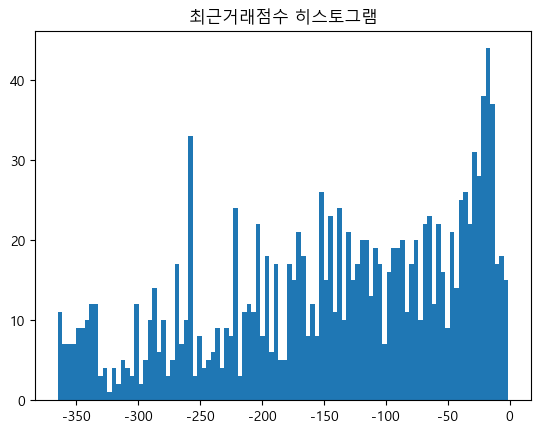

In [43]:
feature_date=pd.to_datetime('2019-12-31')-old_customer['최근거래날짜'] # 메모 12월 31 거래날짜 일치는 6개
feature_data1= -(feature_date.dt.days.values +1)

plt.hist(feature_data1, bins =100);
plt.title('최근거래점수 히스토그램')
plt.show()

`-` 거래빈도

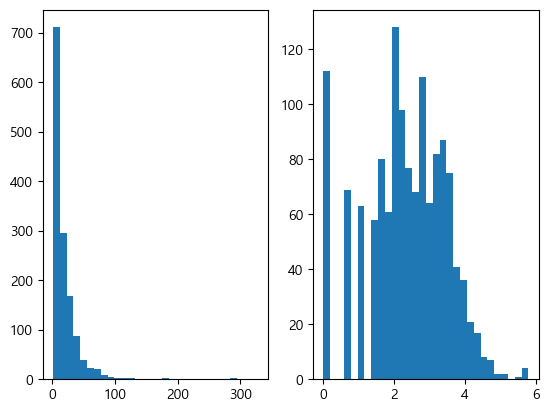

In [42]:
feature_data2=old_customer['거래빈도'].values


fig, ax = plt.subplots(1, 2)
ax[0].hist(feature_data2, bins =30);
#ax[0].set_title('최근거래날짜점수 히스토그램')

ax[1].hist(np.log(feature_data2), bins =30);
#ax[1].set_title('최근거래날짜점수 히스토그램')
plt.show()

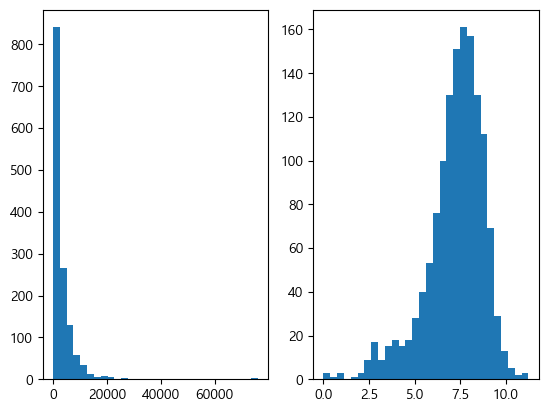

In [40]:
feature_data3=old_customer['거래총금액'].values
fig, ax = plt.subplots(1, 2)
ax[0].hist(feature_data3, bins =30);
#ax[0].set_title('최근거래날짜점수 히스토그램')

ax[1].hist(np.log(feature_data3), bins =30);
#ax[1].set_title('최근거래날짜점수 히스토그램')
plt.show()

In [44]:
cluster_df= pd.DataFrame({'x1':feature_data1,
             'x2':np.log(feature_data2),
             'x3':np.log(feature_data3)})

---


### `-` data 스케일링 
- minmax 방식 채택

In [45]:
from sklearn.preprocessing import *

minmax = MinMaxScaler()
standard = StandardScaler()
cluster_scale =standard.fit_transform(cluster_df)
cluster_scale2 =minmax.fit_transform(cluster_df)

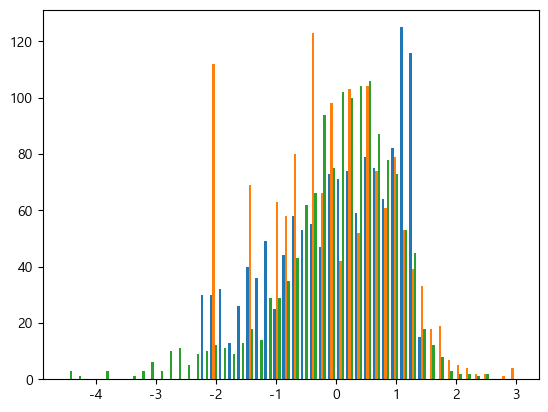

In [46]:
plt.hist(cluster_scale,bins=50);

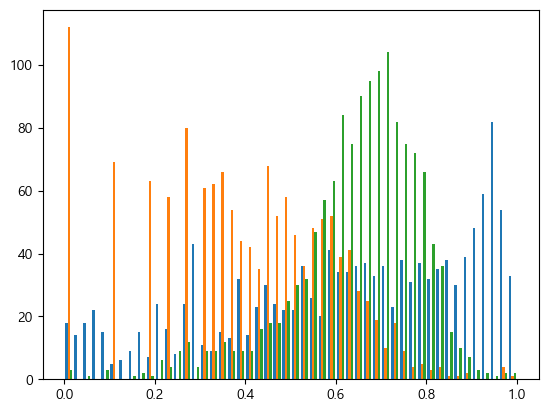

In [47]:
plt.hist(cluster_scale2,bins=50);

---

### 계층적 군집분석 model fitting

In [48]:
from sklearn.cluster import KMeans,AgglomerativeClustering

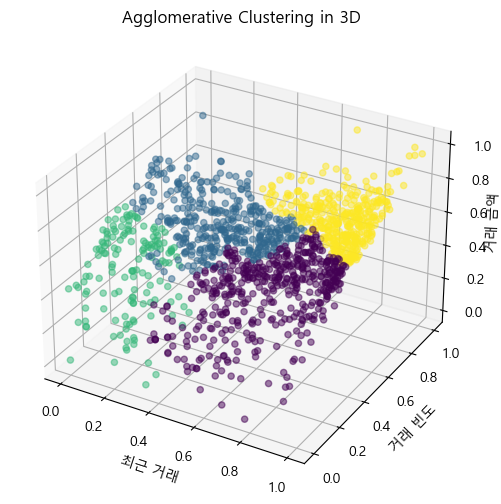

In [49]:
model = AgglomerativeClustering(n_clusters=4,linkage = "complete",
                               compute_full_tree =True,metric='euclidean')
clusters2 = model.fit_predict(cluster_scale2)

# 결과 시각화
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(cluster_scale2[:, 0], cluster_scale2[:, 1], cluster_scale2[:, 2], c=clusters2, cmap='viridis', s=20, alpha=0.5)
ax.set_title('Agglomerative Clustering in 3D')
ax.set_xlabel('최근 거래')
ax.set_ylabel('거래 빈도')
#ax.set_zlabel('거래 금액')
ax.set_zlabel('거래 금액', labelpad=0)
ax.tick_params(axis='z', pad=6)

plt.show()

In [50]:
ddf = pd.DataFrame(cluster_scale2)
ddf['y'] = clusters2
ddf.columns = ['최근성', '최빈성', '금액','y']
ddf.head()

,최근성,최빈성,금액,y
0,0.706044,0.000000,0.305550,0
1,0.837912,0.592781,0.848481,3
2,0.799451,0.358957,0.647276,0
3,0.953297,0.413929,0.642063,0
4,0.706044,0.442766,0.647297,0


---

## 계층적 군집분석 결과

- 0 : 잠재적충성
- 1 : 잠재적이탈
- 2 : 이탈
- 3 : 충성

In [24]:
ddf.groupby('y').mean()

,최근성,최빈성,금액
y,,,
0,0.740539,0.254323,0.550025
1,0.415265,0.458071,0.684958
2,0.170293,0.184581,0.497585
3,0.847785,0.605804,0.772847


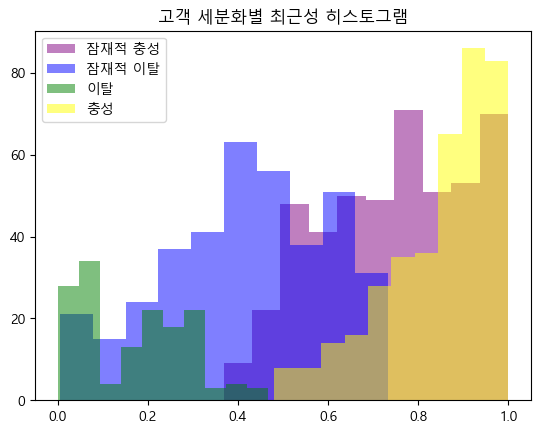

In [51]:
plt.hist('최근성',data=ddf[ddf['y']==0],label='잠재적 충성',alpha=0.5,color = 'purple')
plt.hist('최근성',data=ddf[ddf['y']==1],label='잠재적 이탈',alpha=0.5,color='blue')
plt.hist('최근성',data=ddf[ddf['y']==2],label='이탈',alpha=0.5,color='green')
plt.hist('최근성',data=ddf[ddf['y']==3],label='충성',alpha=0.5,color = 'yellow')
plt.legend()
plt.title("고객 세분화별 최근성 히스토그램")
plt.show()

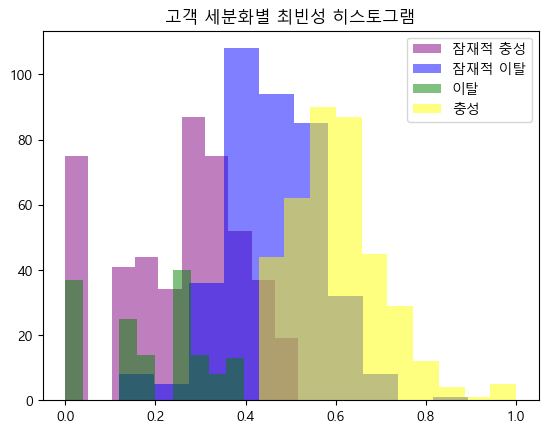

In [52]:
plt.hist('최빈성',data=ddf[ddf['y']==0],label='잠재적 충성',alpha=0.5,color = 'purple')
plt.hist('최빈성',data=ddf[ddf['y']==1],label='잠재적 이탈',alpha=0.5,color='blue')
plt.hist('최빈성',data=ddf[ddf['y']==2],label='이탈',alpha=0.5,color='green')
plt.hist('최빈성',data=ddf[ddf['y']==3],label='충성',alpha=0.5,color = 'yellow')
plt.legend()
plt.title("고객 세분화별 최빈성 히스토그램")
plt.show()

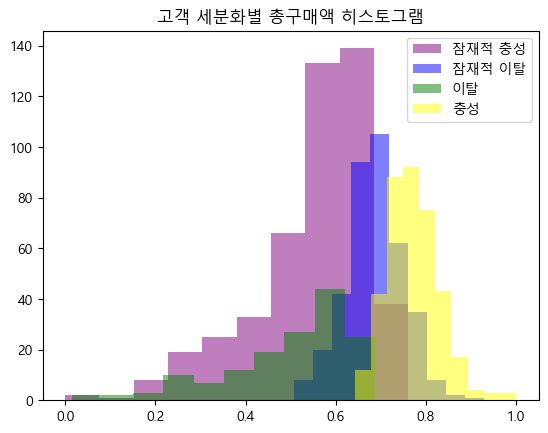

In [53]:
plt.hist('금액',data=ddf[ddf['y']==0],label='잠재적 충성',alpha=0.5,color = 'purple')
plt.hist('금액',data=ddf[ddf['y']==1],label='잠재적 이탈',alpha=0.5,color='blue')
plt.hist('금액',data=ddf[ddf['y']==2],label='이탈',alpha=0.5,color='green')
plt.hist('금액',data=ddf[ddf['y']==3],label='충성',alpha=0.5,color = 'yellow')
plt.legend()
plt.title("고객 세분화별 총구매액 히스토그램")
plt.show()

In [54]:
old_customer_= old_customer.reset_index()
old_customer_['고객등급'] = ddf['y']

potential_in = old_customer_[old_customer_['고객등급'] == 0]['index']
potential_out = old_customer_[old_customer_['고객등급'] == 1]['index']
certainty_out = old_customer_[old_customer_['고객등급'] == 2]['index']
certainty_in = old_customer_[old_customer_['고객등급'] == 3]['index'].values

In [55]:
user_num = np.array([int(df['고객ID'][i][5:]) for i in range(len(df))])
df['user_num'] =user_num # 유저넘버 변수 추가 등급을 찾기 위해서

In [56]:
certainty_in_df = pd.DataFrame({'user_num':certainty_in})
certainty_out_df = pd.DataFrame({'user_num':certainty_out})
potential_in_df = pd.DataFrame({'user_num':potential_in})
potential_out_df = pd.DataFrame({'user_num':potential_out})

In [57]:
# 고객 등급별 특성 추출
certainty_in_customer = pd.merge(df, certainty_in_df,how='inner',on = 'user_num')
certainty_out_customer = pd.merge(df, certainty_out_df,how='inner',on = 'user_num')
potential_in_customer = pd.merge(df, potential_in_df,how='inner',on = 'user_num')
potential_out_customer = pd.merge(df, potential_out_df,how='inner',on = 'user_num')

### 이탈 고객 특징

- 이산형변수

In [51]:
certainty_out_customer.head()

,고객ID,성별,고객지역,가입기간,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,거래금액,user_num
0,USER_0345,여,California,30,Transaction_0013,2019-01-01,Product_0971,Lifestyle,1,1.24,6.5,Clicked,1.24,345
1,USER_1347,여,New Jersey,24,Transaction_0050,2019-01-02,Product_0951,Office,1,3.08,6.5,Clicked,3.08,1347
2,USER_1347,여,New Jersey,24,Transaction_2302,2019-02-04,Product_0976,Nest-USA,1,119.00,6.5,Used,119.00,1347
3,USER_1347,여,New Jersey,24,Transaction_2312,2019-02-04,Product_0177,Bottles,20,2.99,6.5,Clicked,59.80,1347
4,USER_1347,여,New Jersey,24,Transaction_2312,2019-02-04,Product_0285,Apparel,1,16.99,6.5,Clicked,16.99,1347


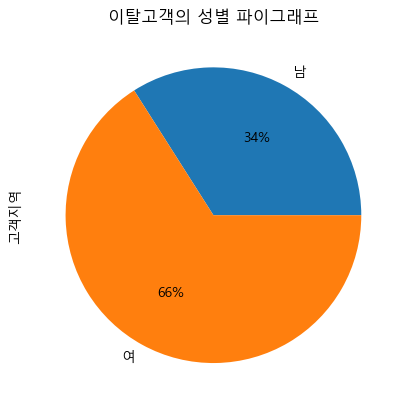

In [52]:
certainty_out_customer.groupby('성별').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('이탈고객의 성별 파이그래프')
plt.show()

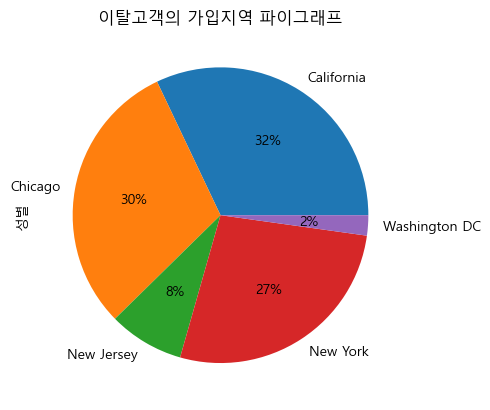

In [53]:
certainty_out_customer.groupby('고객지역').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('이탈고객의 가입지역 파이그래프')
plt.show()

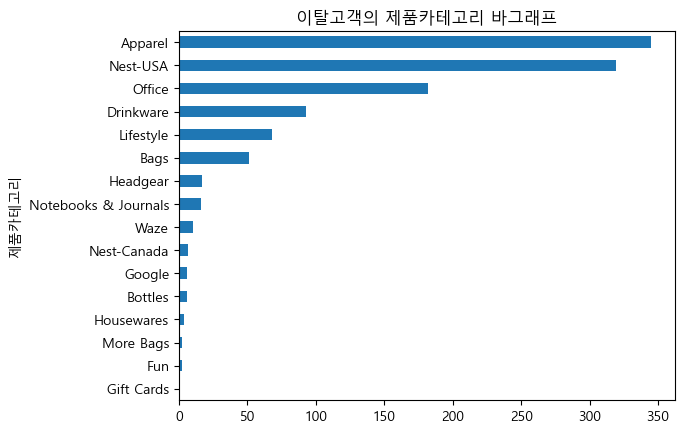

In [54]:
certainty_out_customer.groupby('제품카테고리').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('이탈고객의 제품카테고리 바그래프')
plt.show()

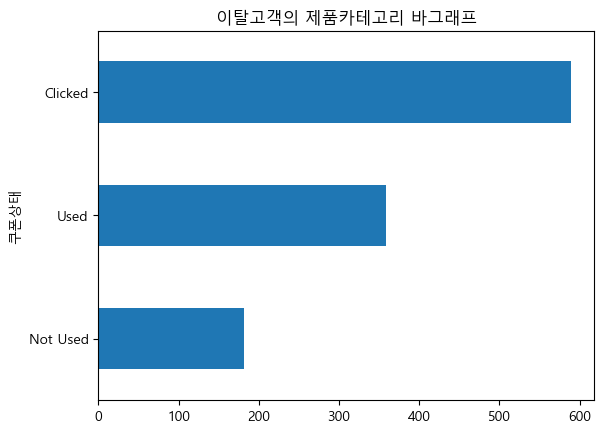

In [55]:
certainty_out_customer.groupby('쿠폰상태').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('이탈고객의 제품카테고리 바그래프')
plt.show()

`-` 연속형 변수

In [56]:
certainty_out_customer.iloc[:,:-1].describe()

,가입기간,수량,평균금액,배송료,거래금액
count,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000
mean,30.192205,4.050487,48.139203,10.601346,75.695031
std,12.385121,12.149633,54.694996,16.063460,93.873973
min,9.000000,1.000000,0.790000,0.000000,0.990000
25%,19.000000,1.000000,4.990000,6.500000,13.590000
50%,32.000000,1.000000,18.990000,6.500000,32.960000
75%,41.000000,2.000000,104.000000,6.500000,122.770000
max,50.000000,155.000000,256.880000,323.470000,768.550000


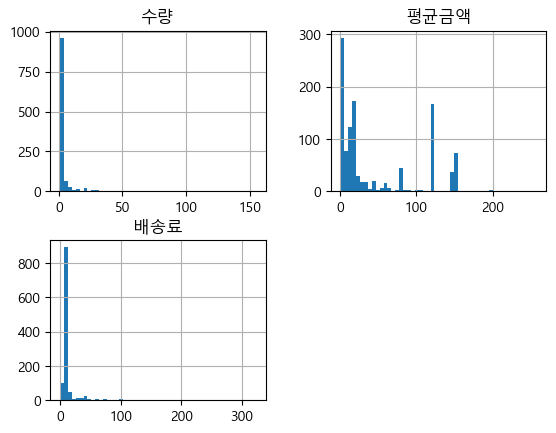

In [57]:
certainty_out_customer[['수량','평균금액','배송료']].hist(bins=50);

---

### 잠재적 이탈 고객 특징
- 이산형변수

In [58]:
potential_out_customer.head()

,고객ID,성별,고객지역,가입기간,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,거래금액,user_num
0,USER_1358,남,Chicago,12,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,153.71,1358
1,USER_1358,남,Chicago,12,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,153.71,1358
2,USER_1358,남,Chicago,12,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,2.05,1358
3,USER_1358,남,Chicago,12,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,87.65,1358
4,USER_1358,남,Chicago,12,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,16.50,1358


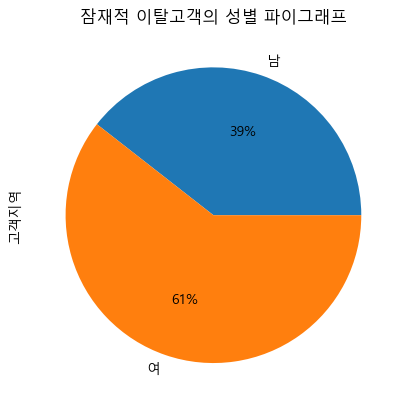

In [59]:
potential_out_customer.groupby('성별').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('잠재적 이탈고객의 성별 파이그래프')
plt.show()

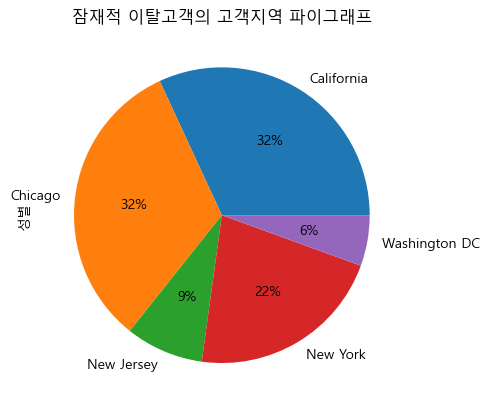

In [60]:
potential_out_customer.groupby('고객지역').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('잠재적 이탈고객의 고객지역 파이그래프')
plt.show()

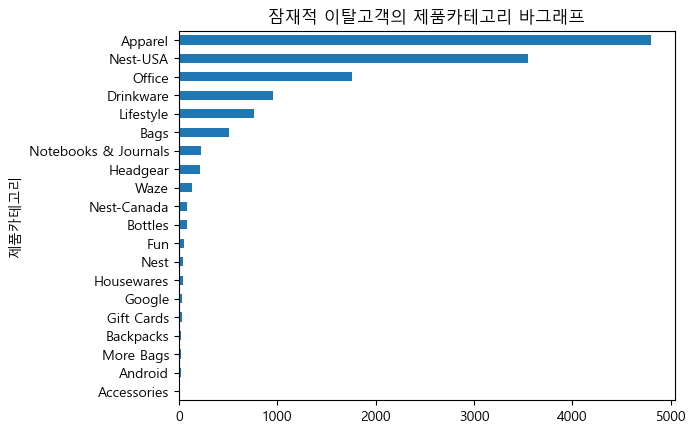

In [61]:
potential_out_customer.groupby('제품카테고리').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('잠재적 이탈고객의 제품카테고리 바그래프')
plt.show()

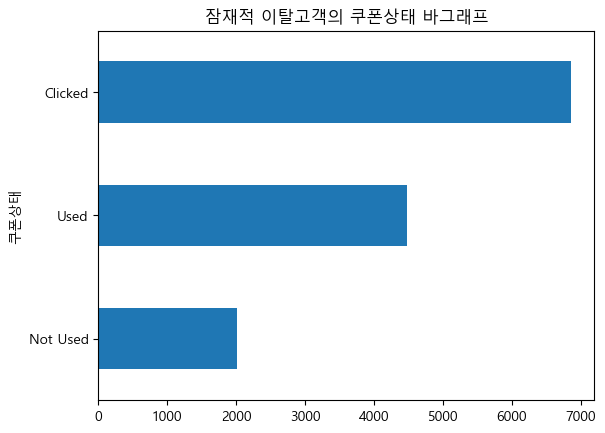

In [62]:
potential_out_customer.groupby('쿠폰상태').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('잠재적 이탈고객의 쿠폰상태 바그래프')
plt.show()

`-` 연속형변수

In [63]:
potential_out_customer.iloc[:,:-1].describe()

,가입기간,수량,평균금액,배송료,거래금액
count,13349.000000,13349.000000,13349.000000,13349.000000,13349.000000
mean,28.500037,4.966365,46.122417,11.255868,81.533906
std,12.080557,20.005820,53.713896,20.411760,132.278413
min,5.000000,1.000000,0.790000,0.000000,0.790000
25%,18.000000,1.000000,6.000000,6.000000,12.790000
50%,29.000000,1.000000,16.500000,6.500000,29.900000
75%,39.000000,2.000000,81.500000,6.500000,119.000000
max,50.000000,600.000000,349.000000,422.240000,5316.000000


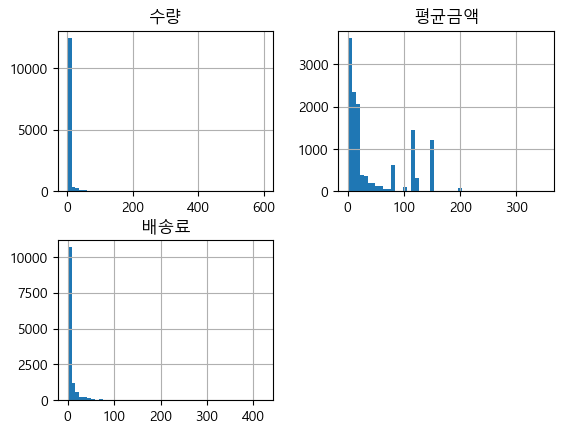

In [64]:
potential_out_customer[['수량','평균금액','배송료']].hist(bins=50);

---

### 잠재적 충성 고객 특성
- 이산형변수

In [65]:
potential_in_customer.head()

,고객ID,성별,고객지역,가입기간,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,거래금액,user_num
0,USER_0683,남,California,49,Transaction_0023,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Clicked,153.71,683
1,USER_0683,남,California,49,Transaction_5384,2019-03-26,Product_0983,Nest-USA,1,119.00,6.50,Clicked,119.00,683
2,USER_0683,남,California,49,Transaction_5689,2019-03-30,Product_0880,Drinkware,5,2.39,12.48,Clicked,11.95,683
3,USER_0683,남,California,49,Transaction_10783,2019-06-19,Product_0981,Nest-USA,5,149.00,12.91,Used,745.00,683
4,USER_0683,남,California,49,Transaction_14636,2019-08-14,Product_0447,Apparel,1,4.08,6.00,Used,4.08,683


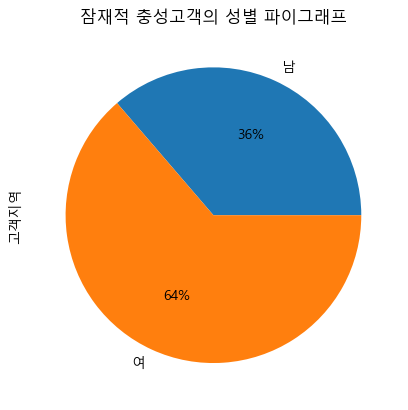

In [66]:
potential_in_customer.groupby('성별').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('잠재적 충성고객의 성별 파이그래프')
plt.show()

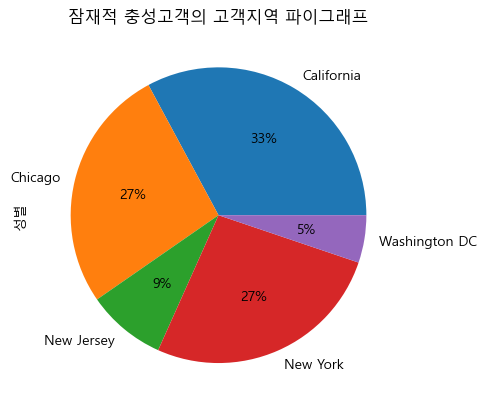

In [67]:
potential_in_customer.groupby('고객지역').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('잠재적 충성고객의 고객지역 파이그래프')
plt.show()

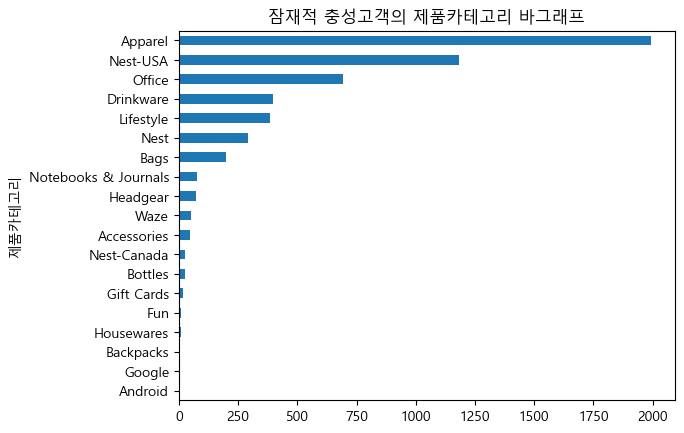

In [68]:
potential_in_customer.groupby('제품카테고리').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('잠재적 충성고객의 제품카테고리 바그래프')
plt.show()

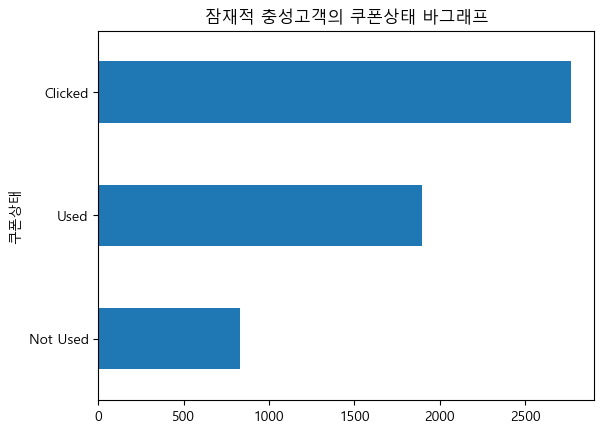

In [69]:
potential_in_customer.groupby('쿠폰상태').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('잠재적 충성고객의 쿠폰상태 바그래프')
plt.show()

`-` 연속형변수

In [70]:
potential_in_customer.iloc[:,:-1].describe()

,가입기간,수량,평균금액,배송료,거래금액
count,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000
mean,26.797996,3.910747,47.322536,10.523754,76.268007
std,13.390032,15.491041,65.641910,26.327441,114.731292
min,3.000000,1.000000,0.400000,0.000000,0.400000
25%,15.000000,1.000000,4.560000,6.000000,9.490000
50%,27.000000,1.000000,13.990000,6.000000,21.990000
75%,38.000000,2.000000,79.000000,6.500000,119.000000
max,50.000000,600.000000,355.740000,504.000000,1495.000000


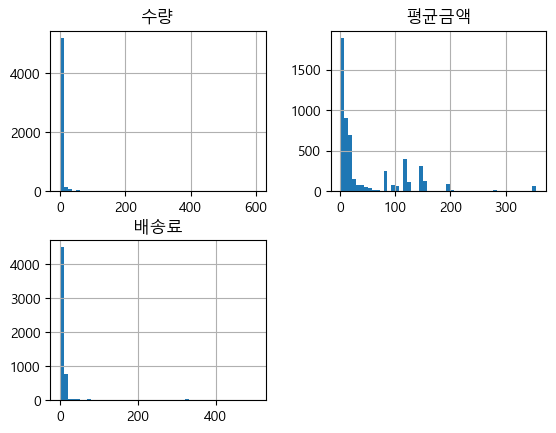

In [71]:
potential_in_customer[['수량','평균금액','배송료']].hist(bins=50);

---

### 충성 고객 특징
- 이산형 변수

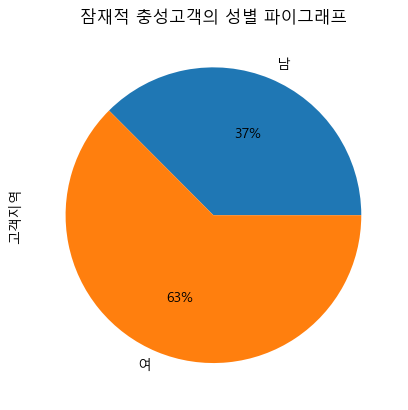

In [72]:
certainty_in_customer.groupby('성별').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('잠재적 충성고객의 성별 파이그래프')
plt.show()

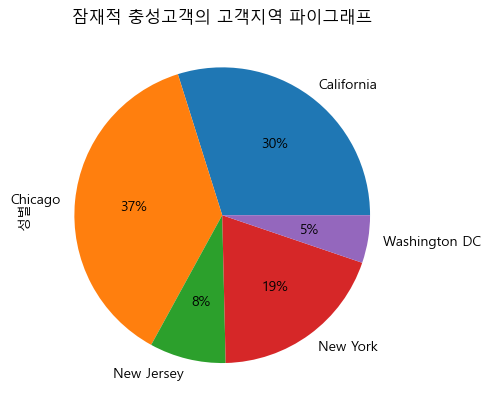

In [73]:
certainty_in_customer.groupby('고객지역').count().iloc[:,1].plot(kind='pie',autopct='%1.f%%');
plt.title('잠재적 충성고객의 고객지역 파이그래프')
plt.show()

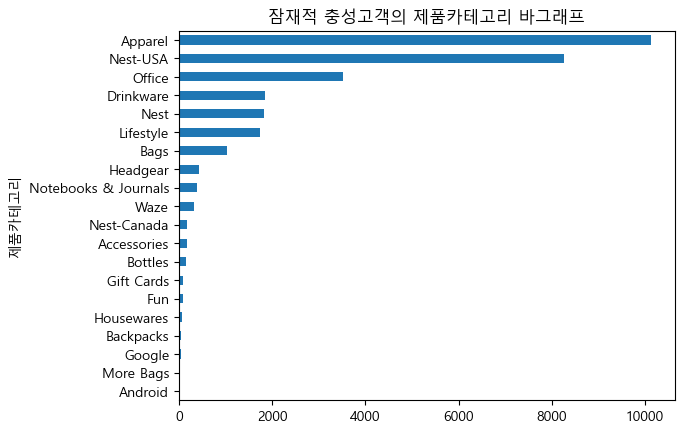

In [74]:
certainty_in_customer.groupby('제품카테고리').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('잠재적 충성고객의 제품카테고리 바그래프')
plt.show()

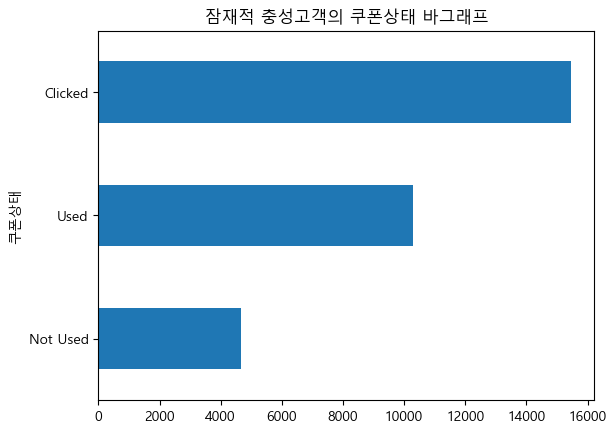

In [75]:
certainty_in_customer.groupby('쿠폰상태').count().sort_values('고객ID').iloc[:,1].plot(kind='barh');
plt.title('잠재적 충성고객의 쿠폰상태 바그래프')
plt.show()

`-` 연속형변수

In [76]:
certainty_in_customer.iloc[:,:-1].describe()

,가입기간,수량,평균금액,배송료,거래금액
count,30406.000000,30406.000000,30406.000000,30406.000000,30406.000000
mean,26.637933,4.430902,56.251541,10.080808,94.395703
std,13.064578,21.503124,68.282826,17.702704,187.951373
min,2.000000,1.000000,0.390000,0.000000,0.400000
25%,16.000000,1.000000,5.990000,6.000000,11.980000
50%,27.000000,1.000000,17.590000,6.000000,33.590000
75%,37.000000,2.000000,119.000000,6.500000,131.850000
max,50.000000,900.000000,355.740000,521.360000,10512.390000


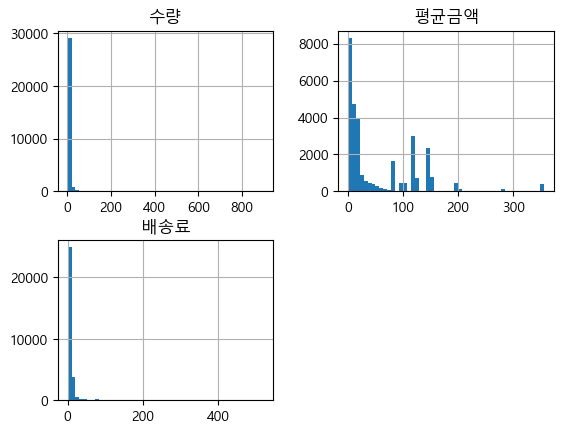

In [77]:
certainty_in_customer[['수량','평균금액','배송료']].hist(bins=50);

---

## 고객 분류 알고리즘
- 비지도학습을 통해 고객 세분화 등급을 딥러닝 모형에 적합
    - feature : 고객의 RFM
    - y_label : 고객 세분화 등급
- 모델설명
    - fully connected layer로 구성, 7개의 히든레이어층
    - 뉴련 512개로 시작하며 절반씩 감소하여 구성
    - 히든레이어마다 드랍아웃 0.2 적용
    - 배치사이즈 4, 학습방식은 adam, 학습률 0.000015
    - softmax, y 확률 반환
    - 입력층 차원 sequence =3, feature=3
    

In [78]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense ,Dropout
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.optimizers import Adam

### train/test set, 원핫인코딩

In [79]:
X = ddf.iloc[:,:3]
y= ddf.iloc[:,3]

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y)

y_train_one_hot = to_categorical(y_train, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)


---

### 딥러닝 모델

In [109]:
K.clear_session()
model0 = Sequential() # Sequeatial Model
model0.add(Dense(512, input_shape=(3, 3),activation='relu'))
model0.add(Dropout(0.2)) # 드롭아웃 적용
model0.add(Dense(256,activation='relu'))
model0.add(Dropout(0.2)) # 드롭아웃 적용
model0.add(Dense(128,activation='relu'))
model0.add(Dropout(0.2)) # 드롭아웃 적용
model0.add(Dense(64,activation='relu'))
model0.add(Dropout(0.2)) # 드롭아웃 적용
model0.add(Dense(32,activation='relu'))
model0.add(Dropout(0.2)) # 드롭아웃 적용
model0.add(Dense(16,activation='relu'))
#model0.add(Dense(64,activation='linear'))
model0.add(Dense(4, activation='softmax')) # output = 1
adam_optimizer = Adam(learning_rate=0.000015)

model0.compile(loss='categorical_crossentropy', optimizer=adam_optimizer ,metrics=['accuracy'])

early_stop = EarlyStopping(monitor='loss', patience=50, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model0.save('my_model.keras')
history= model0.fit(X_train, y_train_one_hot, epochs=200,
          batch_size=4, verbose=1, callbacks=[early_stop, checkpoint],validation_data=(X_test, y_test_one_hot))


Epoch 1/200
229/257 [=========================>....] - ETA: 0s - loss: 1.3945 - accuracy: 0.1517
Epoch 1: val_accuracy improved from -inf to 0.45190, saving model to best_model.h5
257/257 [==============================] - 1s 2ms/step - loss: 1.3939 - accuracy: 0.1537 - val_loss: 1.3846 - val_accuracy: 0.4519
Epoch 2/200
 91/257 [=========>....................] - ETA: 0s - loss: 1.3889 - accuracy: 0.2363

C:\Users\minu\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


254/257 [============================>.] - ETA: 0s - loss: 1.3873 - accuracy: 0.2343
Epoch 2: val_accuracy did not improve from 0.45190
257/257 [==============================] - 0s 2ms/step - loss: 1.3873 - accuracy: 0.2335 - val_loss: 1.3825 - val_accuracy: 0.3761
Epoch 3/200
256/257 [============================>.] - ETA: 0s - loss: 1.3843 - accuracy: 0.2871
Epoch 3: val_accuracy did not improve from 0.45190
257/257 [==============================] - 0s 2ms/step - loss: 1.3842 - accuracy: 0.2879 - val_loss: 1.3791 - val_accuracy: 0.2857
Epoch 4/200
227/257 [=========================>....] - ETA: 0s - loss: 1.3797 - accuracy: 0.3502
Epoch 4: val_accuracy did not improve from 0.45190
257/257 [==============================] - 0s 2ms/step - loss: 1.3797 - accuracy: 0.3405 - val_loss: 1.3734 - val_accuracy: 0.3236
Epoch 5/200
233/257 [==========================>...] - ETA: 0s - loss: 1.3744 - accuracy: 0.3766
Epoch 5: val_accuracy did not improve from 0.45190
257/257 [==================

---

### baseline

- minmax 변환를 제외한 로그 변환은 하지 않음  
- 분포를 고려하지 않았을 때 예측력에 차이가 얼마나 있는지 보기위함
- 모델 세팅 및 학습 횟수는 동일하게 진행

In [131]:
base_X= pd.DataFrame({'x1':feature_data1,
             'x2':feature_data2,
             'x3':feature_data3})
base_X =minmax.fit_transform(base_X)
X_train_b,X_test_b,y_train_b,y_test_b= train_test_split(base_X,y)


y_train_one_hot_b = to_categorical(y_train_b, num_classes=4)
y_test_one_hot_b = to_categorical(y_test_b, num_classes=4)


In [133]:
K.clear_session()
model_base = Sequential() # Sequeatial Model
model_base.add(Dense(512, input_shape=(3, 3),activation='relu'))
model_base.add(Dropout(0.2)) # 드롭아웃 적용
model_base.add(Dense(256,activation='relu'))
model_base.add(Dropout(0.2)) # 드롭아웃 적용
model_base.add(Dense(128,activation='relu'))
model_base.add(Dropout(0.2)) # 드롭아웃 적용
model_base.add(Dense(64,activation='relu'))
model_base.add(Dropout(0.2)) # 드롭아웃 적용
model_base.add(Dense(32,activation='relu'))
model_base.add(Dropout(0.2)) # 드롭아웃 적용
model_base.add(Dense(16,activation='relu'))
#model0.add(Dense(64,activation='linear'))
model_base.add(Dense(4, activation='softmax')) # output = 1
adam_optimizer = Adam(learning_rate=0.000015)

model_base.compile(loss='categorical_crossentropy', optimizer=adam_optimizer ,metrics=['accuracy'])

early_stop = EarlyStopping(monitor='loss', patience=100, verbose=0, restore_best_weights=True)
#checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)
#model_base.save('my_model.keras')
history_base= model_base.fit(X_train_b, y_train_one_hot_b, epochs=1000,
          batch_size=4, verbose=0, callbacks=[early_stop, checkpoint],validation_data=(X_test, y_test_one_hot))

C:\Users\minu\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---

### model0 추가 epoch

In [110]:
early_stop = EarlyStopping(monitor='loss', patience=100, verbose=0, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)
model0.save('my_model.keras')
history2= model0.fit(X_train, y_train_one_hot, epochs=800,
          batch_size=4, verbose=0, callbacks=[early_stop, checkpoint],validation_data=(X_test, y_test_one_hot))


C:\Users\minu\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 모델0 loss 그래프

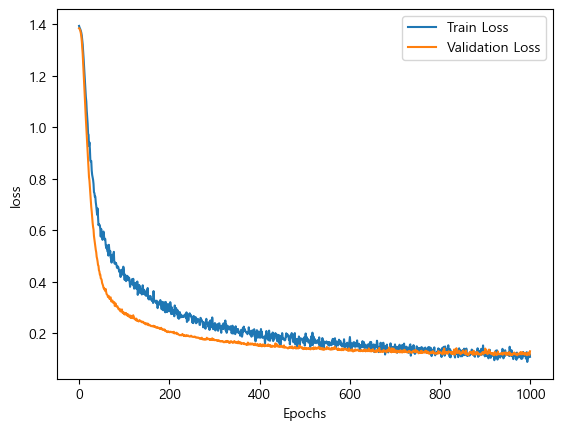

In [121]:
# loss 그래프 
plt.plot(history.history['loss'] + history2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss']+history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

---


### base 모델 loss 그래프

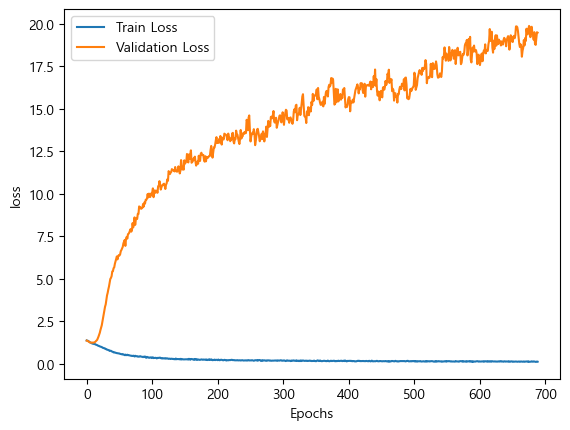

In [142]:
# baseline loss 그래프 
plt.plot(history_base.history['loss'] ,label='Train Loss')
plt.plot(history_base.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

---

### 모델0 accuracy 그래프

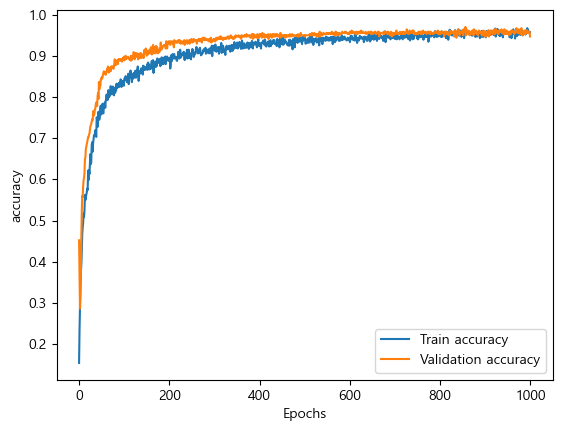

In [123]:
# accuracy 그래프 
plt.plot(history.history['accuracy']+history2.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy']+history2.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

---

### base 모델 accuracy 그래프

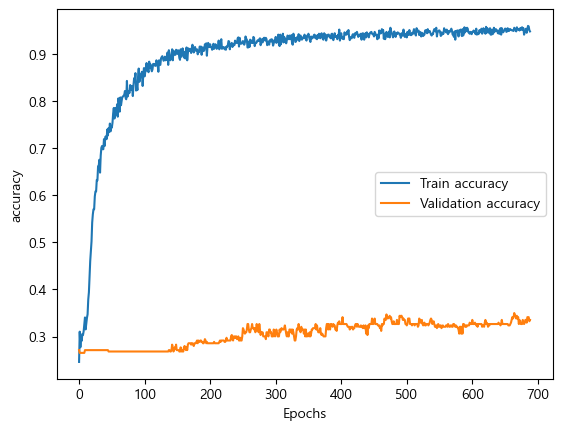

In [143]:
# baseline accuracy 그래프 
plt.plot(history_base.history['accuracy'], label='Train accuracy')
plt.plot(history_base.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [113]:
from keras.models import load_model

# 가장 높은 성능을 보인 모델 불러오기
best_model = load_model('best_model.h5')


In [144]:
pred = model0.predict(X_test)
pred1= best_model.predict(X_test)
pred2 = model_base.predict(X_test_b)

11/11 [==============================] - 0s 988us/step


In [145]:
from sklearn.metrics import accuracy_score

pred_ =np.argmax(pred, axis=1)
pred1_ =np.argmax(pred1, axis=1)
pred2_ =np.argmax(pred2, axis=1)

accuracy = accuracy_score(y_test,pred_)
accuracy1 = accuracy_score(y_test,pred1_)
accuracy2 = accuracy_score(y_test_b,pred2_)
print('basemodel accuracy score : ',accuracy2.round(3))
print('bestmodel accuracy score : ',accuracy1.round(3))

basemodel accuracy score :  0.962
bestmodel accuracy score :  0.971


- 군집분석으로 고객을 세분화후 딥러닝을 통해 고객의 RFM을 학습함
- 딥러닝 모델의 정확성은 98.8%, 학습데이터의 분포가 고객 분류에 있어 상당희 유의하게 잘 만들어진 것을 알 수 있다.

---

# 2. EDA 자료

## 2.1 dacon_마케팅_info_EDA

## 목차

- 시도표 확인
- 분산안정화
- ACF, PACF
- 모형적합

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import*
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.formula.api import *
import statsmodels.stats.api as sms
from statsmodels.graphics.tsaplots import*
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


# 한글깨짐해결
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [9]:
df = pd.read_csv('C:\\Users\\minu\\lab\\dacon0210\\Marketing_info.csv')
df = df.set_index('날짜')
df.head()

,오프라인비용,온라인비용
날짜,,
2019-01-01,4500,2424.50
2019-01-02,4500,3480.36
2019-01-03,4500,1576.38
2019-01-04,4500,2928.55
2019-01-05,4500,4055.30


In [10]:
df.columns

Index(['오프라인비용', '온라인비용'], dtype='object')

In [11]:
df.shape

(365, 2)

In [12]:
df.isnull().sum(axis=0)

오프라인비용    0
온라인비용     0
dtype: int64

- 데이터 정보
    - 칼럼은 3개
        - 날짜, 오프라인비용, 온라인비용
    - shape : 365*3
    - 결측치 없음

- 데이터 변수
    - 날짜 : 시계열 데이터
    - 비용 데이터 : 연속형 데이터
    - 날짜는 데이터프레임에 인덱스로 포함하도록 하겠음
    
- 날짜 : 마케팅이 이루어진 날짜
- 오프라인비용 : 오프라인 마케팅으로 지출한 비용 (단위 : 달러)
- 온라인비용 : 온라인 마케팅으로 지출한 비용 (단위 : 달러)

## 시도표 확인

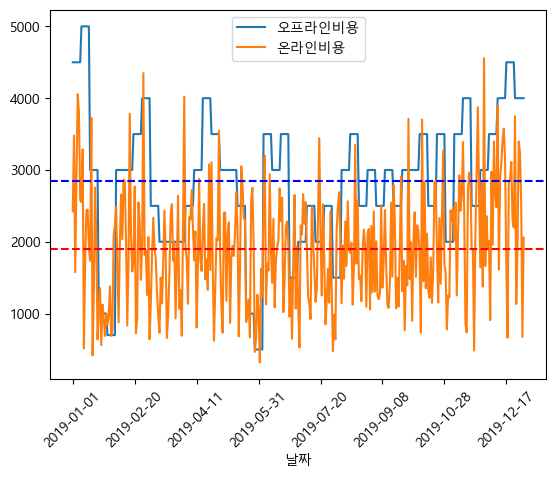

In [15]:
mean_off = df['오프라인비용'].mean()
mean_on =df['온라인비용'].mean()
df.plot();
plt.xticks(rotation=45)
plt.axhline(y=mean_off, color='b', linestyle='--')
plt.axhline(y=mean_on, color='r', linestyle='--')
plt.show()
# plt.set_xticks(np.arange(0,len(df.index)+1,10))

- 마케팅 비용의 오프라인, 온라인 비용의 시도표이다
    - 오프라인 비용이 전반적으로 높은 수준을 지닌 것을 알 수 있음
    - 오프리인 비용은 한번 결정이되면 어느 기간동안 유지되는 것을 알 수 있음
    - 온라인 비용은 비용 변동이 훨씬 크다
    - 이 둘은 비슷한 추세를 따라가는 것으로 보이나, 서로 수준은 달라보인다
    - 각 수평의 파랑, 빨강선은 평균을 의미함, 큰 차이로 벌어져있다.
- 정상시계열 판단
    - 오프라인비용은 어떤 특정값을 유지하는 경향이 있어 정상성을 띄기 어려울 것으로 보인다
    - 온라인비용은 평균에 크게 벗어나지 않고 시도표만으로 비정상 시계열처럼 보이진 않는다.

## 분산안정화

- ARIMA 모형을 적합하여 시계열 데이터의 성분을 파악해보려고 한다.
- 따라서 해당 데이터의 분산을 우선적으로 안정화하는 작업이 필요 
- Breusch-Pagan Test
    - H0 : data가 등분산이다
    - H1 : 등분산이 아니다

In [19]:
# boxcox 변환
#value1, c1 = boxcox(df['오프라인비용'].values)
#value2, c2 = boxcox(df['온라인비용'].values)
t = np.arange(len(df))

df3 = np.log(df)
df['t'] = t
df3['t'] = t

In [20]:

m1 = ols('오프라인비용 ~t',data=df3).fit()
m2 = ols('오프라인비용~t',data=df).fit()
m3 = ols('온라인비용 ~t',data=df3).fit()
m4 = ols('온라인비용~t',data=df).fit()

In [21]:
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
 
test_result = sms.het_breuschpagan(m1.resid, m1.model.exog)
test_result2 = sms.het_breuschpagan(m2.resid, m2.model.exog)
test_result3 = sms.het_breuschpagan(m3.resid, m3.model.exog)
test_result4 = sms.het_breuschpagan(m4.resid, m4.model.exog)


print('오프라인 변환o',test_result[1])
print('오프라인 변환x',test_result2[1])
print('온라인 변환o',test_result3[1])
print('온라인 변환x',test_result4[1])


오프라인 변환o 9.912206603816862e-08
오프라인 변환x 3.906246300317428e-11
온라인 변환o 0.053192390208536625
온라인 변환x 0.5541045010779346


- 오프라인비용은 모든 결과가 유의하지만 그나마 로그변환이 p-value가 더 크게 나왔기 때문에 로그변환 진행
- 온라인비용은 로그변환을 하지 않았을 때, 영가설을 기각하지 못하므로 변환하지 않겠다.

## acf, pacf 도표

### 오프라인 비용 성분파악

In [24]:
date_range = pd.date_range(start='2019-01-01', end='2019-12-31', freq='D')

on_cost = pd.Series(df['온라인비용'].values,index=date_range)
off_cost = pd.Series(df3['오프라인비용'].values,index=date_range)

C:\Users\minu\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


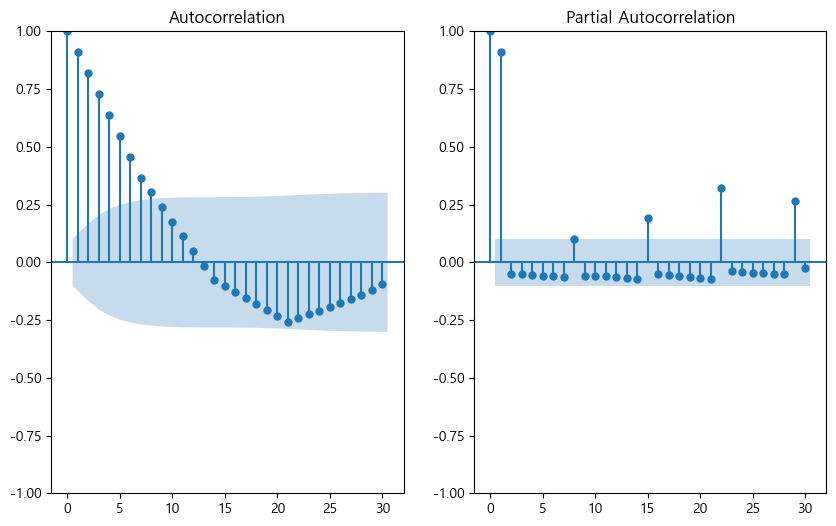

In [25]:
%matplotlib inline

fig, ax = plt.subplots(1,2,figsize=(10, 6))
plot_acf(off_cost, lags=30, ax=ax[0]);
plot_pacf(off_cost, lags=30, ax=ax[1]);

- 오프라인 비용에 대한 ACF, PACF 도표이다
    - ACF, PACF 도표를 통해 기각역에 크게벗어나는 것을 확인 비정상 시계열이다.
    - ACF 도표를 통해 천천히 감소하는 양상을 확인할 수 있어 추세 차분이 필요로 해보인다
    - PACF 도표를 통해 특정 주기마다 기각역을 벗어나는 양상을 보인다. 계절 차분을 진행하려고 함
    - 또한 PACF 2번째까지 기각역을 벗어난뒤 절단이라 AR 모형이 고려할만하다

### 추세 차분

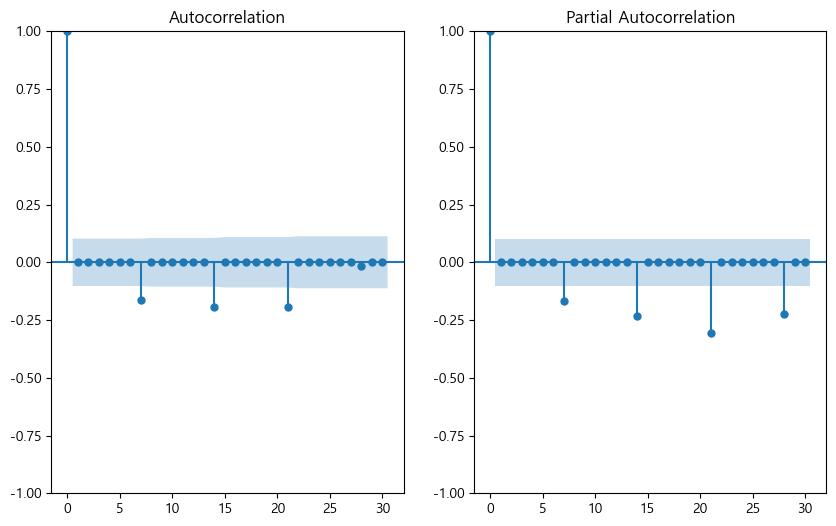

In [29]:
off_cost_diff = off_cost.diff(1).dropna(axis=0)
fig, ax = plt.subplots(1,2,figsize=(10, 6))
plot_acf(off_cost_diff, lags=30, ax=ax[0]);
plot_pacf(off_cost_diff, lags=30, ax=ax[1]);

- 추세를 차분한 ACF, PACF의 도표이다
    - ACF의 도표를 통해 추세성분이 제거되었다. 하지만 일정 주기마다 기각역을 벗어나는 
    경우가 있음
    - PACF 또한 ACF의 같은 주기마다 기각역을 벗어남
    - 계절성이 존재한다.

### 계절차분

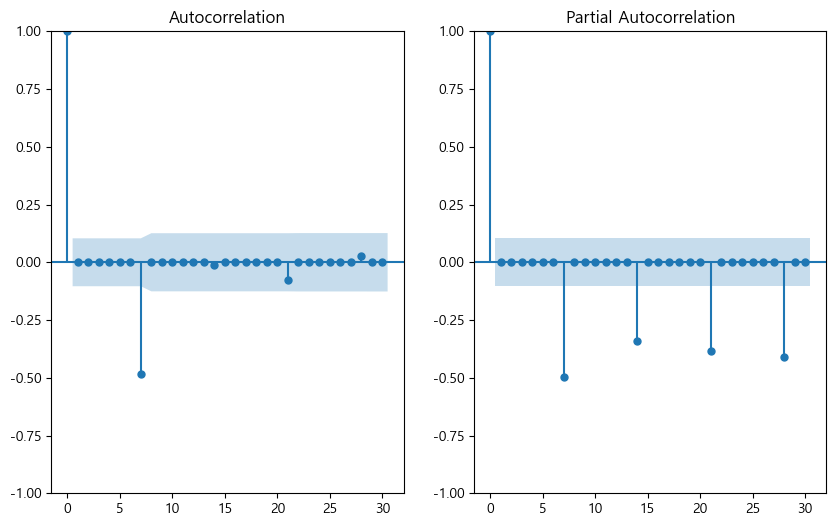

In [31]:
off_cost_diff7 = off_cost.diff(1).diff(7).dropna(axis=0)

fig, ax = plt.subplots(1,2,figsize=(10, 6))
plot_acf(off_cost_diff7, lags=30, ax=ax[0]);
plot_pacf(off_cost_diff7, lags=30, ax=ax[1]);

- 계절차분을 진행한 ACF. PACF 도표이다.
    - 시계열 데이터가 day로 기록되어 있기 때문에 일주일 단위인 7로 계절 차분을 진행하였다.
    - ACF에서 2번째로 기각역에 벗어난 시차를 제외하고 나머지가 기각역에 들어갔으며
    - PACF는 아직 주기성이 존재함으로 계절형 SMA모형이 고려된다

## 온라인비용 성분파악

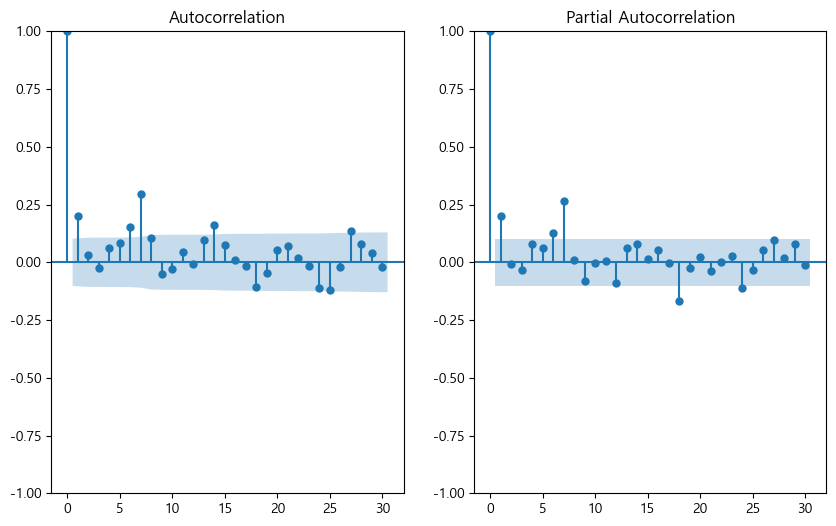

In [35]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))
plot_acf(on_cost, lags=30, ax=ax[0]);
plot_pacf(on_cost, lags=30, ax=ax[1]);

- 온라인비용에 대한 ACF, PACF 모형이다. 
- 대부분의 시차가 기각역에 들어가 있지만 특정 시차가 튀어나와있다.
- 추세성분은 시도표 및 ACF에서도 보이지 않으니 차분은 하지 않고 계절차분만 진행해보려한다.
- 계절차분이 성공적이지 않으면 바로 모형을 적합해볼만하다. ACF와 PACF 1차시 이후 크게 절단이 되어있으므로 ARMA(1,1)모형이 고려되어진다.

###  차분 단위근 검정

- 차분이 필요한지 단위근 검정을 통해 알아보려한다
    - H0 : 단위근이 존재한다
    - H1 : 단위근이 존재하지 않는다

In [38]:
result = adfuller(on_cost,regression = 'n')
print('영가설을 기각할까?', 'No' if result[1] > 0.05 else 'Yes')
#print('ADF Statistic:', result[0])
print('p-value:', result[1])
#print('Critical Values:', result[4])


영가설을 기각할까? No
p-value: 0.5281497373729626


- 영가설을 기각하지 못했으므로 단위근은 존재한다. 추세차분을 진행하고 정상시계열이 아님을 보이는 증거를 얻었다

### 정상성 검정

- H0 : 정상성 시계열
- H1 : not 정상 시계열

In [41]:
result = kpss(on_cost)
print('영가설을 기각할까?', 'No' if result[1] > 0.05 else 'Yes')
print('p-value:', result[1])  

영가설을 기각할까? Yes
p-value: 0.01


C:\Users\minu\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


- 영가설을 기각하므로 대립가설 채택, 정상시계열이 아님을 보여주는 증거를 얻었다

### 온라인 마케팅 비용 계절차분

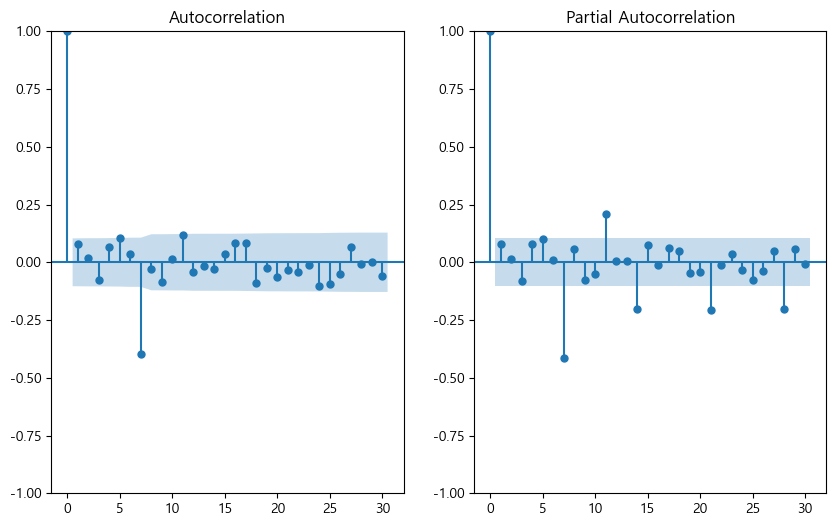

In [44]:
on_cost_diff7 = on_cost.diff(7).dropna(axis=0)
fig, ax = plt.subplots(1,2,figsize=(10, 6))
plot_acf(on_cost_diff7, lags=30, ax=ax[0]);
plot_pacf(on_cost_diff7, lags=30, ax=ax[1]);

- 온라인비용에 대한 계절차분을 진행한 도표이다
    - 마찬가지로 주기를 7로 계절성분을 차분하였다.
    - ACF의 대다수의 시차가 기각역에 포함되었지만 PACF는 계절성이 두드러지게 나타난다.
    - 이는 계절차분을 진행할 것인지에 대해 선택사항인데 모형의 단순함을 위해 계절차분은 진행
    않도록한다

# 정리

- 오프라인 비용은 추세차분과 계절차분 진행, 그리고 SMA(1)모형을 적합
$$
(1-B)(1-\Theta_1 B^7)(Zt-\mu) = \epsilon_t
$$


- 온라인 비용은 차분없이 ARIMA(1,0,1) 모형을 우선 적합
$$
(1-\phi_1 B)(1-B)(Zt-\mu) = (1-\theta_1 B)\epsilon_t
$$

# 모형적합

`-` **알림**
- 모형적합하고 예측이 주된 것이 아니고 데이터에 대한 성분을 파악하기 위함
- 잔차분석과 다른 모형과의 비교는 생략하도록 하겠다

### 오프라인 비용 data 

In [48]:
order = (0, 1, 0) 
seasonal_order = (0, 0, 1, 7)  
m1 = ARIMA(off_cost,order = order,seasonal_order=seasonal_order)
m1_fit= m1.fit()
m1_fit.summary()
#simulated_data = m1_fit.simulate(nsimulations=365)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  365
Model:             ARIMA(0, 1, 0)x(0, 0, [1], 7)   Log Likelihood                 121.719
Date:                           Sun, 25 Feb 2024   AIC                           -239.439
Time:                                   21:02:56   BIC                           -231.644
Sample:                               01-01-2019   HQIC                          -236.341
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.8871      0.015    -59.997      0.000      -0.916      -0.858
sigma2         0.0291      0.000     62.293      0.000       0.028       0.030
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             26665.07
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -4.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

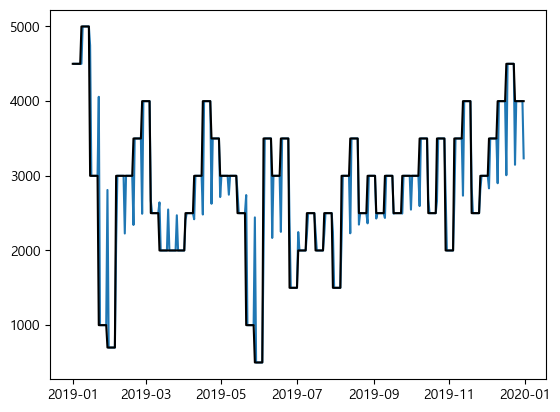

In [50]:
m1pred = m1_fit.predict(start = '2019-01-01',end = '2019-12-31', typ='levels')
plt.plot(np.exp(m1pred[1:]))
plt.plot(np.exp(off_cost),color = 'black')

- fitted data를 이용해 다시 predict를 한 것으로 얼마나 모형이 적합이 잘되었는지 보여준다.
- 실제 observed data와는 달리 주기성이 더 강하게 예측이 되었다.
- 하지만 전반적인 데이터의 형태는 정확히 따라가고 있음

### 온라인 비용

In [53]:
order = (1, 1, 1) 
#seasonal_order = (0, 0, 0)  
m2 = ARIMA(on_cost,order = order)
m2_fit= m2.fit()
m2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2944.708
Date:                Sun, 25 Feb 2024   AIC                           5895.416
Time:                        21:03:26   BIC                           5907.107
Sample:                    01-01-2019   HQIC                          5900.063
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1455      0.060      2.425      0.015       0.028       0.263
ma.L1         -0.9667      0.015    -64.970      0.000      -0.996      -0.938
sigma2      6.188e+05   4.46e+04     13.877      0.000    5.31e+05    7.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.95
Prob(Q):                              0.95   Prob(JB):                         0.14
Heteroskedasticity (H):               0.98   Skew:                             0.25
Prob(H) (two-sided):                  0.89   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

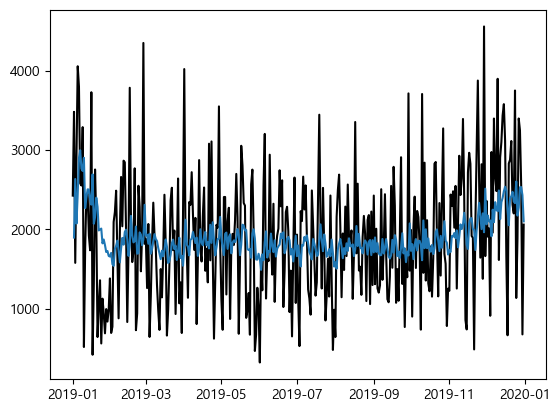

In [54]:
m2pred = m2_fit.predict(start = '2019-01-01',end = '2019-12-31', typ='levels')

plt.plot(on_cost,color = 'black')
plt.plot(m2pred[1:])

- 실제 observed data는 분산이 매우 큰 것으로 보인다.
- predict 결과는 평균을 따라 소극적으로 예측된 것을 확인할 수 있다
- 분산이 크다는 것은 움직이는 영역이 넓다는 의미로 보면 된다.
    - 즉 온라인 비용의 가격 변동이 영역이 매우 크다.
    - 유지하고자하는 성질이 적으며, 이것은 domain에 대한 어떤 영향이 큰 것으로 보임

---

## 2.2 데이콘 온라인세일 정보 데이터분석

- 목차
    - 이산형 변수 EDA
    - 연속형 변수 EDA
    - 연속형 변수 회귀분석

In [63]:
df = pd.read_csv('C:\\Users\\minu\\lab\\dacon0210\\Onlinesales_info.csv')
df.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used


In [64]:
df.columns

Index(['고객ID', '거래ID', '거래날짜', '제품ID', '제품카테고리', '수량', '평균금액', '배송료', '쿠폰상태'], dtype='object')

In [65]:
df.shape

(52924, 9)

In [66]:
df.isnull().sum(axis=0)

고객ID      0
거래ID      0
거래날짜      0
제품ID      0
제품카테고리    0
수량        0
평균금액      0
배송료       0
쿠폰상태      0
dtype: int64

- 데이터 변수
    - 이산형 변수 : 고객, 거래, 제품, 카테고리, 쿠폰상태
    - 연속형 변수 : 수량, 평균금액, 배송료

In [67]:
class df_tool():
    def __init__(self,df,feature1):
        self.df = df.reset_index()
        self.feature1 = feature1
        
    def DFcount(self):
        df_count= self.df.groupby(self.feature1).count().sort_values('index',ascending=False)[['index']]
        print('{}의 중복되지 않는 수 :'.format(self.feature1),df_count.shape[0])
        self.df_count = df_count
        return self.df_count
    
    def DFdistribution(self,n):
        #print('{} 집계 수의 히스토그램'.format(self.feature1))
        fig, ax = plt.subplots(1,2,figsize=(8, 6))
        #hist= self.df_count.hist(bins=n)
        ax[0].hist(self.df_count,n)
        ax[1].boxplot(self.df_count, labels =' ')

## 이산형 변수 EDA

### 고객ID

In [70]:
tool1 = df_tool(df,'고객ID')
tool1.DFcount().head()

고객ID의 중복되지 않는 수 : 1468


,index
고객ID,
USER_0118,695
USER_0736,587
USER_0563,575
USER_1355,572
USER_0643,523


In [71]:
tool1.df_count.describe()

,index
count,1468.000000
mean,36.051771
std,50.885680
min,1.000000
25%,10.000000
50%,21.000000
75%,46.000000
max,695.000000


- 평균적인 고객의 이커머스의 이용은 36회이다
- 단 최댓값이 매우 높은 것으로 특정 고객이 이용률이 매우 높다
- 이용률이 높은 고객과 낮은 고객이 어떤 특성을 지닌지 확인해볼만 하다.

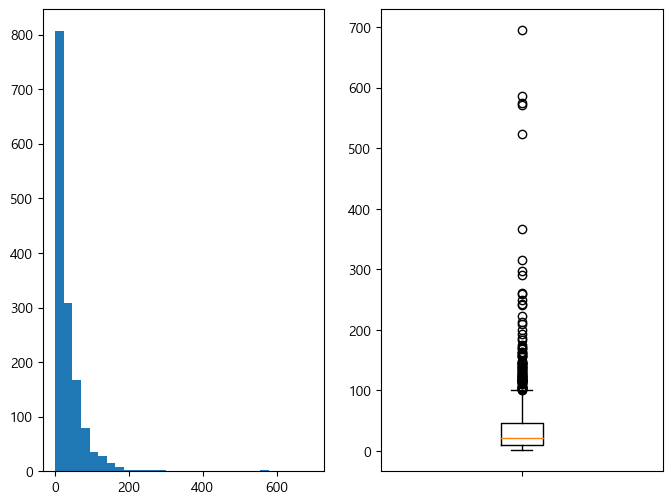

In [73]:
tool1.DFdistribution(30)

- 특정 고객이 매우 높은 거래율을 보여준다.
- 대부분이 주문율이 0~30회 구간에 쏠려있는 것을 확인할 수 있다

### 거래ID

- 고객 ID와 거래 ID의 차이를 정확히 인지할 필요가 있다
- 아직까진 정확히 무슨 기준으로 나누어진 것인지 애매하다.
- 같은 고객 ID여도 거래 ID의 차이가 있고 반대로 같은 거래 ID이지만 고객 ID가 다른경우가 있다. 
- 고객의 특성을 볼 때 고객 ID를 활용할 수 있고 거래와 관련된 특성을 확인할 때 거래 ID가 필요해보인다.
- 일단 거래ID가 고객이 구매를 진행할 때 나온 기록 데이터라고 가정하고 분석을 하도록 하겠음

In [76]:
tool2 = df_tool(df,'거래ID')
tool2.DFcount().head()

거래ID의 중복되지 않는 수 : 25061


,index
거래ID,
Transaction_12261,35
Transaction_4716,30
Transaction_19047,29
Transaction_13487,28
Transaction_16759,27


In [77]:
tool2.df_count.describe()

,index
count,25061.000000
mean,2.111807
std,2.177670
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,35.000000


- 평균적인 거래는 2회
- 상위 75%의 값또한 2회로 쏠려 있고 중앙값은 1회이므로 분포자체가 오른쪽이 매우긴 분포가 예상되어진다.
- 특정 고객만이 계속 이커머스를 통해 거래를 하는 경향이 있다는 것을 알 수 있음
- 그 특정 고객이 가진 특성과 다른 일반 고객의 특성의 차이가 무엇인지 확인이 필요해보인다

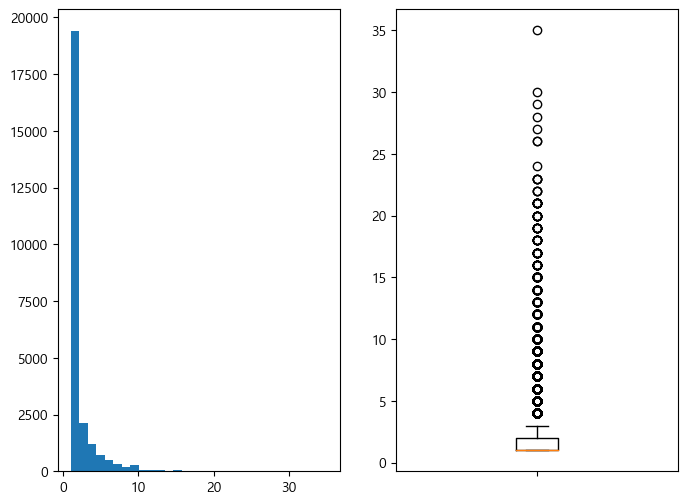

In [79]:
tool2.DFdistribution(30)

### 제품 ID

In [81]:
tool3 = df_tool(df,'제품ID')
tool3.DFcount().head()

제품ID의 중복되지 않는 수 : 1145


,index
제품ID,
Product_0981,3511
Product_0983,3328
Product_0976,3230
Product_0984,1361
Product_0989,1089


- 제품 ID의 카운트가 높을수록 구매자가 많다라고 볼 수 있거나 특정 고객이 대량을 구매한다라고 볼 수 있다.

In [83]:
tool3.df_count.describe()

,index
count,1145.000000
mean,46.221834
std,193.262109
min,1.000000
25%,6.000000
50%,15.000000
75%,32.000000
max,3511.000000


- 평균은 46회
- 중앙값이 15회, 75% 값이 32회인 것으로 보아 마찬가지로 오른쪽이 매우 긴 분포를 형성하고 있겠다.
- 즉 몇몇 제품이 압도적인 구매율을 나타낸다는 것으로 볼 수 있다.

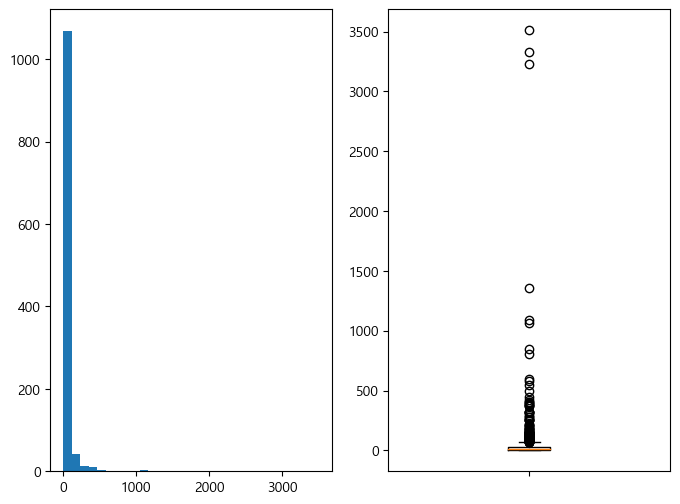

In [85]:
tool3.DFdistribution(30)

### 제품카테고리

In [90]:
tool4 = df_tool(df,'제품카테고리')
tool4.DFcount().head()

제품카테고리의 중복되지 않는 수 : 20


,index
제품카테고리,
Apparel,18126
Nest-USA,14013
Office,6513
Drinkware,3483
Lifestyle,3092


In [91]:
tool4.df_count.index.values

array(['Apparel', 'Nest-USA', 'Office', 'Drinkware', 'Lifestyle', 'Nest',
       'Bags', 'Headgear', 'Notebooks & Journals', 'Waze', 'Nest-Canada',
       'Bottles', 'Accessories', 'Fun', 'Gift Cards', 'Housewares',
       'Google', 'Backpacks', 'More Bags', 'Android'], dtype=object)

- 제품 카테고리는 다른 이산형변수보다 변수 폭이 좁다

In [93]:
tool4.df_count.describe()

,index
count,20.000000
mean,2646.200000
std,4915.767912
min,43.000000
25%,149.750000
50%,435.500000
75%,2421.500000
max,18126.000000


- 평균은 약 2646회
- 중앙값이 435회, 75% 값이 2421회인 것으로 보아 마찬가지로 오른쪽이 매우 긴 분포를 형성하고 있겠다.
- 즉 몇몇 제품의 카테고리가 압도적인 구매율을 보여줄 것으로 보인다

<Axes: ylabel='제품카테고리'>

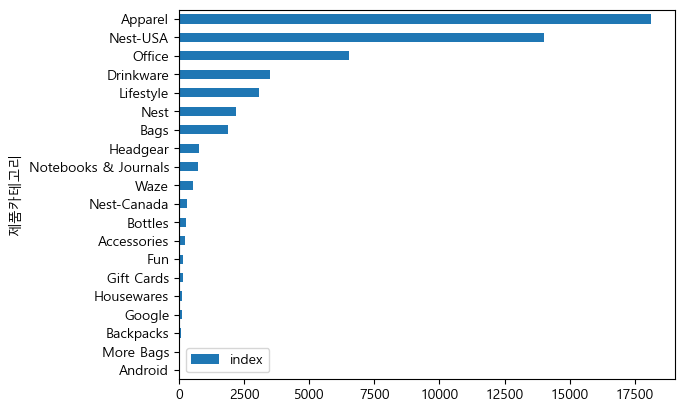

In [94]:
tool4.df_count.sort_values('index').plot(kind = 'barh')

- 제품 카테고리의 바그래프이다.
- Apparel, Nest-usa, office, drinkware, lifestyle순으로 가장 많은 카테고리를 차지하고 있다.

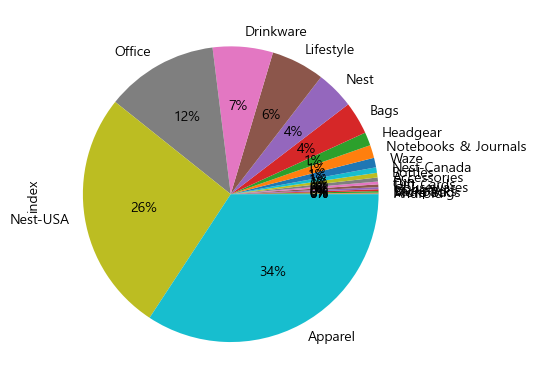

<Figure size 2000x2000 with 0 Axes>

In [96]:
tool4.df_count.sort_values('index')['index'].plot(kind = 'pie',autopct='%1.f%%')
plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 6})

plt.show()

- 파이차트이다
- 인기 카테고리 5개가 85%를 차지하고 있다

### 쿠폰상태

In [99]:
tool5 = df_tool(df,'쿠폰상태')
tool5.DFcount().head()

쿠폰상태의 중복되지 않는 수 : 3


,index
쿠폰상태,
Clicked,26926
Used,17904
Not Used,8094


In [100]:
clicked_but_not_used= tool5.df_count.iloc[0,:] - tool5.df_count.iloc[1,:]
not_click_and_not_used= clicked_but_not_used - tool5.df_count.iloc[2,:]
print('쿠폰을 클릭했지만 사용하지 않음',clicked_but_not_used.values)
print('쿠폰을 클릭조차 하지 않음',not_click_and_not_used.values)

쿠폰을 클릭했지만 사용하지 않음 [9022]
쿠폰을 클릭조차 하지 않음 [928]


- 쿠폰의 이용 상태이다,
    - 쿠폰을 클릭한 횟수는 26926회
    - 사용한 횟수는 17904회
    - 사용하지 않은 횟수는 8094회이다.
- 여기서 쿠폰을 사용하기 위해서는 클릭을 해야하기 때문에 used는 clicked와 관련이 있다.
- 또한 clicked에서 used를 뺀 값은 쿠폰을 클릭하고도 사용하지 않은 횟수이며 이는 not used값과 다름

<Axes: >

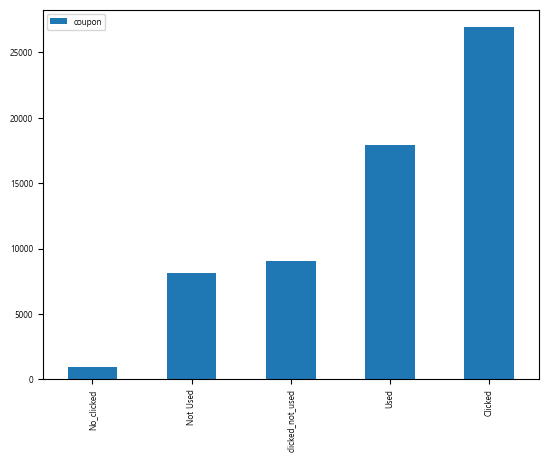

In [102]:
coupon_values= np.concatenate([tool5.df_count.values.flatten(),clicked_but_not_used.values,not_click_and_not_used.values],axis=0)
coupon_index= tool5.df_count.index.values.flatten().tolist() +['clicked_not_used','No_clicked']

df_coupon = pd.DataFrame({'coupon':coupon_values},coupon_index)
df_coupon.sort_values('coupon').plot(kind = 'bar')

- 쿠폰의 이용 현황을 나타낸 바그래프이다

##  연속형 변수 EDA

In [106]:
df_con = df.loc[:,['수량','평균금액','배송료']]
df_con.describe()

,수량,평균금액,배송료
count,52924.000000,52924.000000,52924.000000
mean,4.497638,52.237646,10.517630
std,20.104711,64.006882,19.475613
min,1.000000,0.390000,0.000000
25%,1.000000,5.700000,6.000000
50%,1.000000,16.990000,6.000000
75%,2.000000,102.130000,6.500000
max,900.000000,355.740000,521.360000


- 수량, 평균금액, 배송료 변수 전부다 평균보다 중앙값이 더 낮은 공통점이 존재한다
- 분포는 오른쪽이 긴꼬리를 형성할 것이고 기준은 평균보다 중앙값을 잡는 것이 좋아보인다

`-` 수량
- 수량은 맥시멈 값이 상당히 높은데 대량구매로 보여진다. 고객의 특성이 도매업, 소매업, 또는 대량 구매를 하는 쪽일 것이다.
- 대체적으로 구매할 때 수량은 2개를 넘지 않을 것

`-` 평균금액
- 평균금액은 물건 하나의 평균적인 금액을 의미한다.
- 금액에 따른 수량 또는 금액에 따른 고객의 특성을 볼 수 있겠다

`-` 배송료
- 배송료는 배송료가 측정되어지는 기준이 중요해보인다
- 운송하는 거리, 산간지역이나 섬 등 지역의 특성을 고려해서 배송료가 큰 편차로 벌어질 것

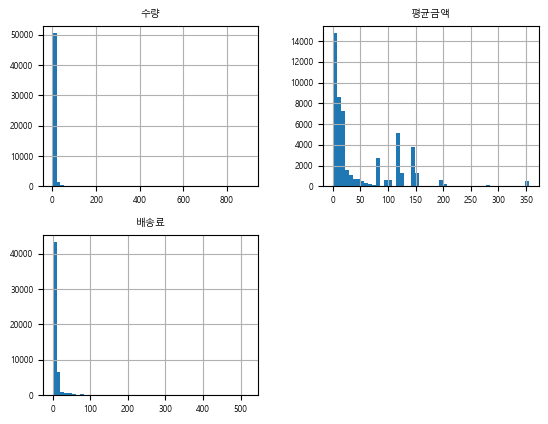

In [108]:
df_con.hist(bins=50);

- 수량과 배송료는 극단적으로 분포가 매우 치우쳐져 있다
- 평균금액 또한 마찬가지로 왼쪽에 쏠려 있지만 중앙에 봉우리 하나가 더 형성되있다.
    - 이는 대부분의 많은 구매 물품은 저가로 형성되어있지만 특정 어떤 물품인 경우는 사람들이 비싸더라도 많이 구매하는 것으로 볼 수 있다

### 연속형 변수 산점도

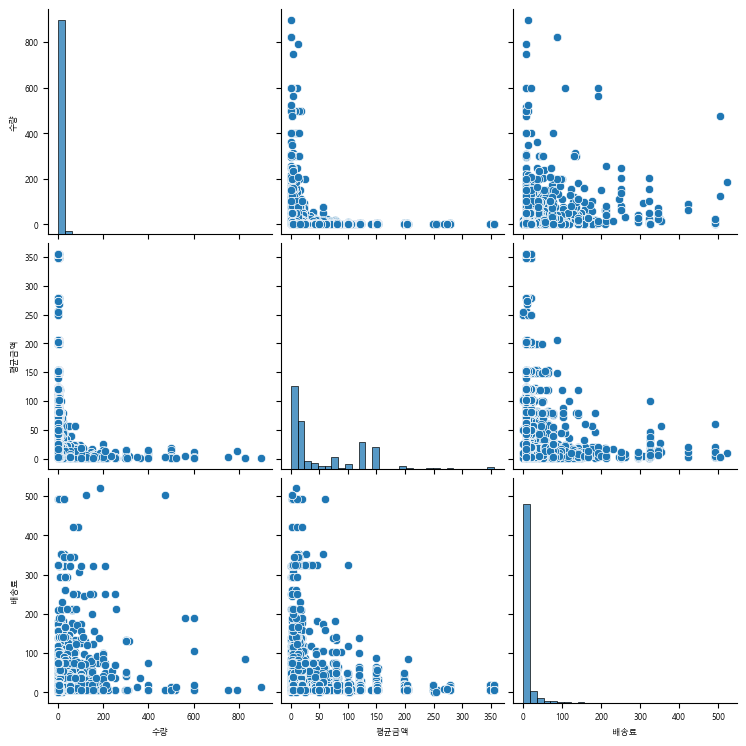

In [111]:
import seaborn as sns
sns.pairplot(df_con,diag_kws={'bins': 30});


- 변수들 간의 상관관계가 두드러지는 특징이 관찰되지 않는다

In [112]:
df_con.corr()

,수량,평균금액,배송료
수량,1.000000,-0.113996,0.191383
평균금액,-0.113996,1.000000,-0.107799
배송료,0.191383,-0.107799,1.000000


- 상관관계의 구체적인 수치 또한 서로 큰 상관성이 있다고 보이지 않는다
- 이는 보통 물건의 금액이 비싸면 배송료가 싸다는 것이나 또는 배송료가 비싸다는 것은 물건의 금액이 비싸다라는 인식은 맞지 않다고
말하는 지표라고 볼 수 있다

- 다만 이는 물건의 카테고리에 따라 다를 수가 있겠는데, 어떤 물건은 가격은 비싸지만 운송이 어려워 배송료가 높아질 수도 있고 어떤 물건은 가격은 비싸더라도 운송이 쉬워 배송료가 낮아질 수가 있다. 따라서 물건을 카테고리로 나눠서 다시 변수간의 관계를 보는 것이 좋아보인다

### 연속형 변수 회귀분석

- 각 변수를 타겟으로 설정하여 회귀분석 모형을 돌린 결과이다
- 해당 결과로 타겟과 설명변수가 어떤 사이에 있는지를 대략 알 수 있는 지표가 된다

In [116]:
import statsmodels.api as sm
from statsmodels.formula.api import *

### 평균금액 타겟

In [118]:
m1 =ols('평균금액 ~수량+배송료',df_con).fit()

m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   평균금액   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     558.5
Date:                Sun, 25 Feb 2024   Prob (F-statistic):          9.75e-241
Time:                        21:09:57   Log-Likelihood:            -2.9465e+05
No. Observations:               52924   AIC:                         5.893e+05
Df Residuals:                   52921   BIC:                         5.893e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     56.7105      0.315    180.179      0.000      56.094      57.327
수량            -0.3085      0.014    -22.112      0.000      -0.336      -0.281
배송료           -0.2933      0.014    -20.364      0.000      -0.322      -0.265
==============================================================================
Omnibus:                    16449.346   Durbin-Watson:                   1.174
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49211.380
Skew:                           1.630   Prob(JB):                         0.00
Kurtosis:                       6.418   Cond. No.                         27.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 결정계수가 매우 낮음 변수의 변동성을 잘 설명한 것은 아니다
- 하지만 각 변수의 t-value가 매우 높다. f 통계량도 매우 높다
- 이는 각 변수 끼리의 관계 자체는 서로 유의한 어떤 점이 있을 것으로 보임
- 또한 수량과 배송료의 계수가 음수인 것으로 보아 금액이 증가할 수록 수량 또는 배송료는 감소하는 관계에 있다고 볼 수 있다

### 수량 타겟

In [121]:
m2 =ols('수량 ~평균금액+배송료',df_con).fit()

m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     수량   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1260.
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        21:10:26   Log-Likelihood:            -2.3269e+05
No. Observations:               52924   AIC:                         4.654e+05
Df Residuals:                   52921   BIC:                         4.654e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0802      0.123     33.253      0.000       3.840       4.321
평균금액          -0.0297      0.001    -22.112      0.000      -0.032      -0.027
배송료            0.1871      0.004     42.416      0.000       0.178       0.196
==============================================================================
Omnibus:                   114084.552   Durbin-Watson:                   1.384
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        666683222.028
Skew:                          19.342   Prob(JB):                         0.00
Kurtosis:                     551.481   Cond. No.                         119.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 위 첫번째 모델과 같이 모형자체의 적합성을 논하기 어렵다
- 변수들의 계수가 금액은 음수이고 배송료는 양수이다
    - 물건의 수량이 증가할 때마다, 평균금액은 떨어지고 배송료는 오른다는 것
    - 이는 대량 구입하면 할인을 더 붙일 수 있다는 의미이고, 물건의 개수는 많으니 배송할 때 양이 많아져 배송료는 오를수 있다는 의미로 해석되어진다

### 배송료 타겟

In [124]:
m3 =ols('배송료 ~평균금액+수량',df_con).fit()

m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    배송료   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1221.
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        21:10:38   Log-Likelihood:            -2.3104e+05
No. Observations:               52924   AIC:                         4.621e+05
Df Residuals:                   52921   BIC:                         4.621e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1117      0.110    100.971      0.000      10.896      11.327
평균금액          -0.0265      0.001    -20.364      0.000      -0.029      -0.024
수량             0.1758      0.004     42.416      0.000       0.168       0.184
==============================================================================
Omnibus:                    89720.174   Durbin-Watson:                   0.469
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         93311016.587
Skew:                          11.711   Prob(JB):                         0.00
Kurtosis:                     207.368   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 모형의 적합성은 위 모델들처럼 논하기가 어렵다
- 변수간의 관계는 평균금액이 음수, 수량이 양수이다.
    - 2번째 모델 설명과 일치한다

---

# 2.3  데이콘 이커머스 고객 데이터 분석

`-` 목차

1. EDA 기초
    - 고객성별 파이차트
    - 고객지역 파이차트
    - 가입기간 히스토그램 및 박스플랏
2. EDA 데이터 관계 파악
    - 가입기간 중심으로
    - 고객성별과 고객지역

In [130]:
df_customer = pd.read_csv('C:\\Users\\minu\\lab\\dacon0210\\Customer_info.csv')


In [131]:
df_customer.columns.values

array(['고객ID', '성별', '고객지역', '가입기간'], dtype=object)

In [132]:
df_customer.shape

(1468, 4)

In [133]:
df_customer.isnull().sum(axis=0)

고객ID    0
성별      0
고객지역    0
가입기간    0
dtype: int64

`-` 데이터 shape 정보

- 고객 정보 데이터 
    - 칼럼은 총 4개
        - 고객 ID, 성별, 고객지역, 가입기간
    - 1468의 행으로 이루어짐
    - 결측치 없음
    
`-` 데이터 변수 정보

- 이산형 변수
    - 고객ID, 성별, 고객지역
- 연속형 변수
    - 가입기간
    
`-` 기타사항

- 고객ID 변수는 어떠한 정보를 담고 있긴 어려움, 따라서 일단은 활용 X

## EDA 기초

### 고객 성별 파이차트

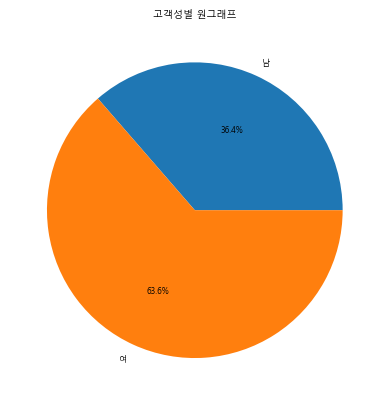

In [137]:
gender_count= df_customer.groupby('성별').count().iloc[:,0].values
gender_labels = df_customer.groupby('성별').count().index

plt.pie(gender_count,labels=gender_labels,autopct='%.1f%%');
plt.title("고객성별 원그래프")
plt.show()

- 고객의 성별 비율을 나타낸 원그래프
- 남성이 36.4%, 여성이 63.6%을 차지하고 있다
- 여성이 남성보다 약 2배가량 비율이 높은 것을 확인할 수 있음

### 고객 지역 원그래프

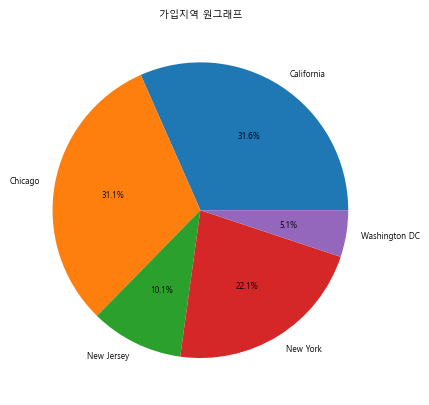

In [142]:
area_count= df_customer.groupby('고객지역').count().iloc[:,0].values
area_labels = df_customer.groupby('고객지역').count().index

plt.pie(area_count,labels=area_labels,autopct='%.1f%%');
plt.title("가입지역 원그래프")
plt.show()

- 가입지역의 비율을 나타낸 원그래프
- 총 5개의 지역으로 나누어져 있다.
    - 캘리포니아 31.6%
    - 시카고 31.1%
    - 뉴욕 22.1%
    - 뉴저지 10.1%
    - 워싱턴 5.1%
- 단 이 비율의 차이가 해당 이커머스 서비스의 지역별 선호도라고 보기는 매우 어렵다
- 각 지역의 총 인구 수에 비례하여 다른 플랫폼과의 얼마나 차이가 나는지 모르기 때문이다

### 가입기간 히스토그램

`-` 가입기간(단위:월) 통계량

- 월, 년 단위

In [145]:
mon , year =df_customer[['가입기간']].describe(),df_customer[['가입기간']].describe() /12

pd.concat([mon,year],axis=1).iloc[1:,:]

,가입기간,가입기간
mean,25.912125,2.159344
std,13.959667,1.163306
min,2.000000,0.166667
25%,14.000000,1.166667
50%,26.000000,2.166667
75%,38.000000,3.166667
max,50.000000,4.166667


- 평균은 약 26개월, 표준편차는 13개월
- 중위값 26개월, 최솟값 2개월, 최댓값 50개월
- 평균과 중위값의 차이가 크지 않음, 분포가 비교적 대칭적일 것

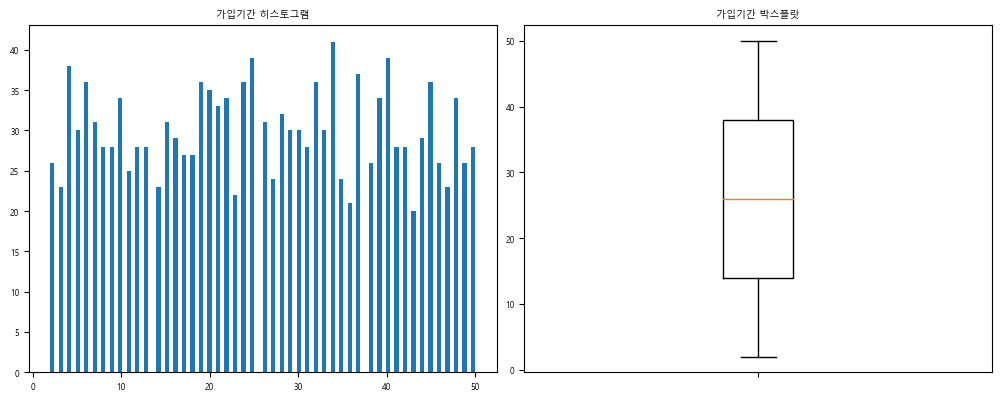

In [147]:
#term_conut = df_customer.groupby('가입기간').count().iloc[:,0].values

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1) 
plt.hist(df_customer[['가입기간']], bins=100);
plt.title("가입기간 히스토그램")
#plt.show()

plt.subplot(1, 2, 2) 
plt.boxplot(df_customer[['가입기간']],labels=' ');
plt.title("가입기간 박스플랏")

plt.tight_layout() 
plt.show()

- 히스토그램
    - 가입기간 구간이 특정 주차마다 몰려있는 것을 확인
    - 어떤 다른 데이터와 연관이 있을 것으로 예상(예를들어 광고로 인한 해당 시기에 가입유저의 증가)
- 박스플랏
    - 특이사항 x
    - 이상치 x

## EDA Data간 관계 파악

- 해당 데이터는 3개의 이산형 변수와 1개의 연속형 변수로 이루어져 있다.
- 따라서 유일하게 연속형 변수인 가입기간을 중심으로 나머지 이산형 변수와 어떤 관계성 또는 특이성있는지 파악해보려한다.

### 가입기간과 성별 박스플랏 및 통계량

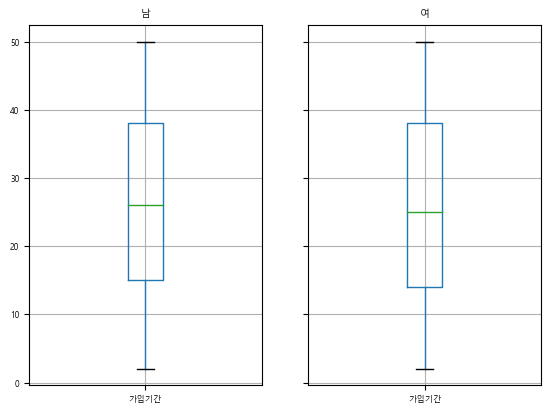

In [152]:
df_customer.groupby('성별').boxplot();

- 박스플랏 상으로 큰 유의점을 찾기 어렵다
- 따라서 분포의 큰 차이는 없을 것으로 보인다

In [154]:
df_customer.groupby('성별').describe()

가입기간                                                   
    count       mean        std  min   25%   50%   75%   max
성별                                                          
남   534.0  26.329588  13.743700  2.0  15.0  26.0  38.0  50.0
여   934.0  25.673448  14.083406  2.0  14.0  25.0  38.0  50.0

- 마찬가지로 남녀 비율의 차이가 있을 뿐이지 통계량에 유의한 차이점은 존재하기 어렵다
- 다만 여성이 남성보다 가입기간의 평균이 약소하게 낮으며, 표준편차가 좀더 크다
    - 남성보다 여성의 신규 고객이 더 활발히 들어 올 것임을 남녀 카운트의 차이와 평균의 차이로 해석할 수도 있겠다

### 가입기간과 고객지역 박스플랏 및 통계량

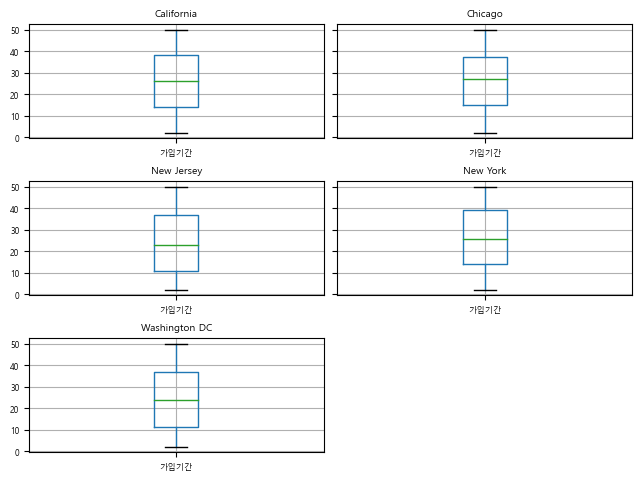

In [157]:
df_customer.groupby('고객지역').boxplot();
plt.tight_layout() 
plt.show()

- 지역마다 가입기간의 분포의 차이는 있어보이지 않는다
- 이상치 또한 있어보이지 않는다

In [158]:
df_customer.groupby('고객지역').describe()

가입기간                                                    
               count       mean        std  min   25%   50%    75%   max
고객지역                                                                    
California     464.0  26.122845  13.881790  2.0  14.0  26.0  38.00  50.0
Chicago        456.0  26.228070  13.550904  2.0  15.0  27.0  37.25  50.0
New Jersey     149.0  24.328859  14.847169  2.0  11.0  23.0  37.00  50.0
New York       324.0  26.070988  14.159788  2.0  14.0  25.5  39.00  50.0
Washington DC   75.0  25.146667  14.344877  2.0  11.5  24.0  37.00  50.0

- 통계량 또한 유의한 차이는 나타나지 않는다.
- 다만 뉴저지가 평균이 조금 떨어지긴 하나 표준편차를 보았을 때 같은 분포로 보임
    - <주의> 엄밀하게는 분포에 대한 검정은 해야한다

### 성별과 고객지역 바그래프 및 통계량

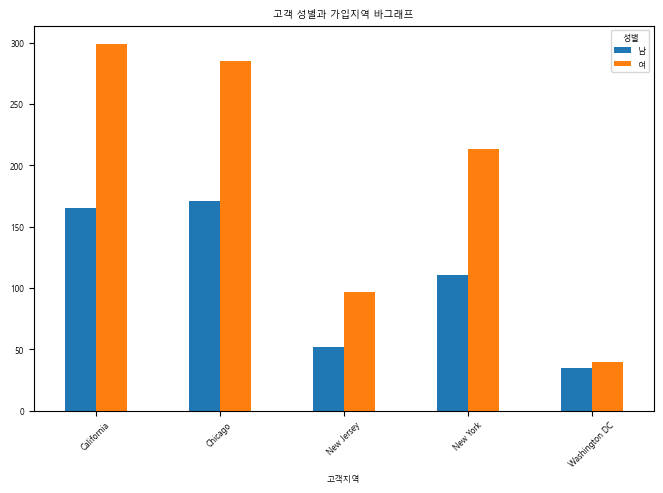

In [162]:
table = pd.pivot_table(df_customer[['성별','고객지역']],aggfunc=len,  index=['고객지역'], columns=['성별'])
table.plot(kind='bar', stacked=False, figsize=(8, 5))
plt.xticks(rotation=45)
plt.title('고객 성별과 가입지역 바그래프')
plt.show()

- 여성이 모든 지역에서 남성보다 고객의 수가 많다
- 단 유일하게 워싱턴DC 지역은 여성과 남성의 차이가 매우 작은 편이다

### 정리

- 성별과 고객지역을 각각 가입기간으로 관계를 파악해본 결과, 이들은 서로 크리티컬한 영향을 주는 변수가 아닐 것으로 보여진다. 왜냐하면 성별과 고객지역으로 가입기간의 분포를 각각 보았을 때, 분포에 유의한 변화가 거의 없었기 때문이다. 따라서 성별과 고객지역은 고객가입기간에 있어 영향을 주는 요소로 보기 어렵다고 생각되어진다.


- 어찌보면 너무 당연한 것일 수도 있다. 가입기간이라는 변수는 가입하고 나서의 기간임을 의미하는데, 성별이나 지역 상관없이 가입하기만 한다면 동일하게 기간이 지나가기 때문이다. 하지만 성별이나 지역에 따라 가입 기간의 변화가 크게 나타난다면 특정 시기에 어떤 사건이 있다고 볼 수 있겠지만 해당 데이터는 그러한 것이 나타나지 않은 것 같다.


- <주의> 가입**기간**에 영향을 주지 않아 보인다는 것이지 고객의 **가입** 자체에는 충분히 관련이 있을 수 있다.
    - 성별의 비율만 봐도 여성이라는 성별은 남성보다 고객 유치가 조금 더 수월할 것임을 알 수 있다.
    - 따라서 고객의 가입은 고객의 가입 기간과는 별개로 봐야한다. 
    
    
- 가입지역과 고객 성별 이 둘의 관계는 중요한 요소가 아닐 것으로 생각되어진다. 해당 지역 총 인구의 성비, 수는 주어진 데이터에서 알지 못하기 때문에 더 이상의 해석이 어려워짐

---

# 추가 제시 자료
- 아이디어 솔루션 영역에서 사용한 데이터 분석, 시각화 자료

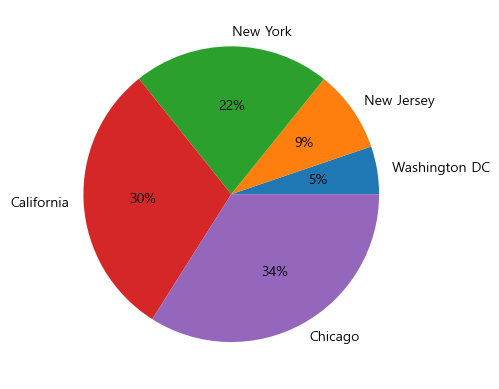

In [36]:
df.query("제품카테고리 == 'Apparel'").groupby('고객지역').count()[['고객ID']].sort_values(by='고객ID').plot(kind='pie',subplots=True,
                                                                                              ylabel=" ",autopct='%1.f%%')
plt.xticks(rotation = 45)
plt.legend().remove()

plt.show()

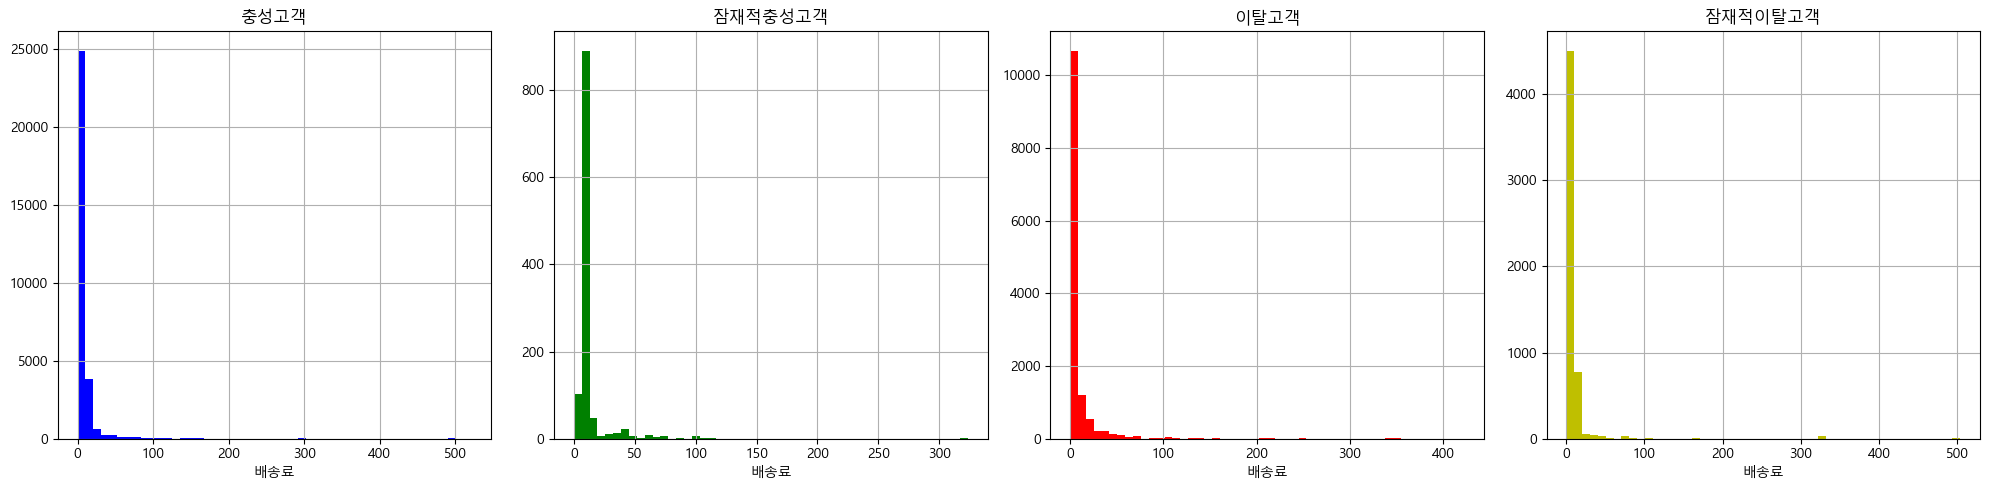

In [73]:

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=False)

# 각 서브플롯에 히스토그램 그리기
certainty_in_customer['배송료'].hist(bins=50,ax=axs[0], color='b')
potential_in_customer['배송료'].hist(bins=50, ax=axs[3], color='y')
certainty_out_customer['배송료'].hist(bins=50, ax=axs[1], color='g')
potential_out_customer['배송료'].hist(bins=50, ax=axs[2], color='r')


# 각 서브플롯에 제목 추가
axs[0].set_title('충성고객')
axs[1].set_title('잠재적충성고객')
axs[2].set_title('이탈고객')
axs[3].set_title('잠재적이탈고객')

# x축 레이블 추가
for ax in axs:
    ax.set_xlabel('배송료')

# 그래프 간 간격 조절
plt.tight_layout()

# 그래프 보여주기
plt.show()


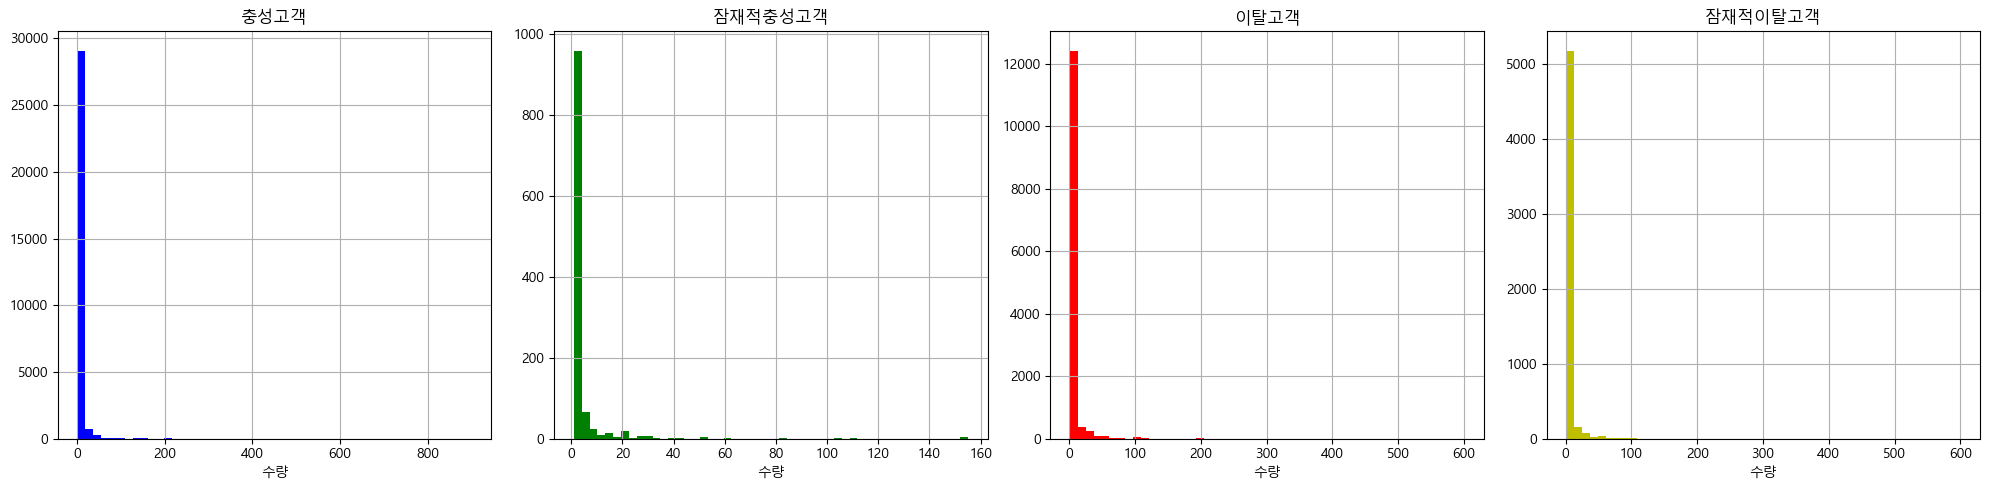

In [76]:

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=False)

# 각 서브플롯에 히스토그램 그리기
certainty_in_customer['수량'].hist(bins=50,ax=axs[0], color='b')
potential_in_customer['수량'].hist(bins=50, ax=axs[3], color='y')
certainty_out_customer['수량'].hist(bins=50, ax=axs[1], color='g')
potential_out_customer['수량'].hist(bins=50, ax=axs[2], color='r')


# 각 서브플롯에 제목 추가
axs[0].set_title('충성고객')
axs[1].set_title('잠재적충성고객')
axs[2].set_title('이탈고객')
axs[3].set_title('잠재적이탈고객')

# x축 레이블 추가
for ax in axs:
    ax.set_xlabel('수량')

# 그래프 간 간격 조절
plt.tight_layout()

# 그래프 보여주기
plt.show()

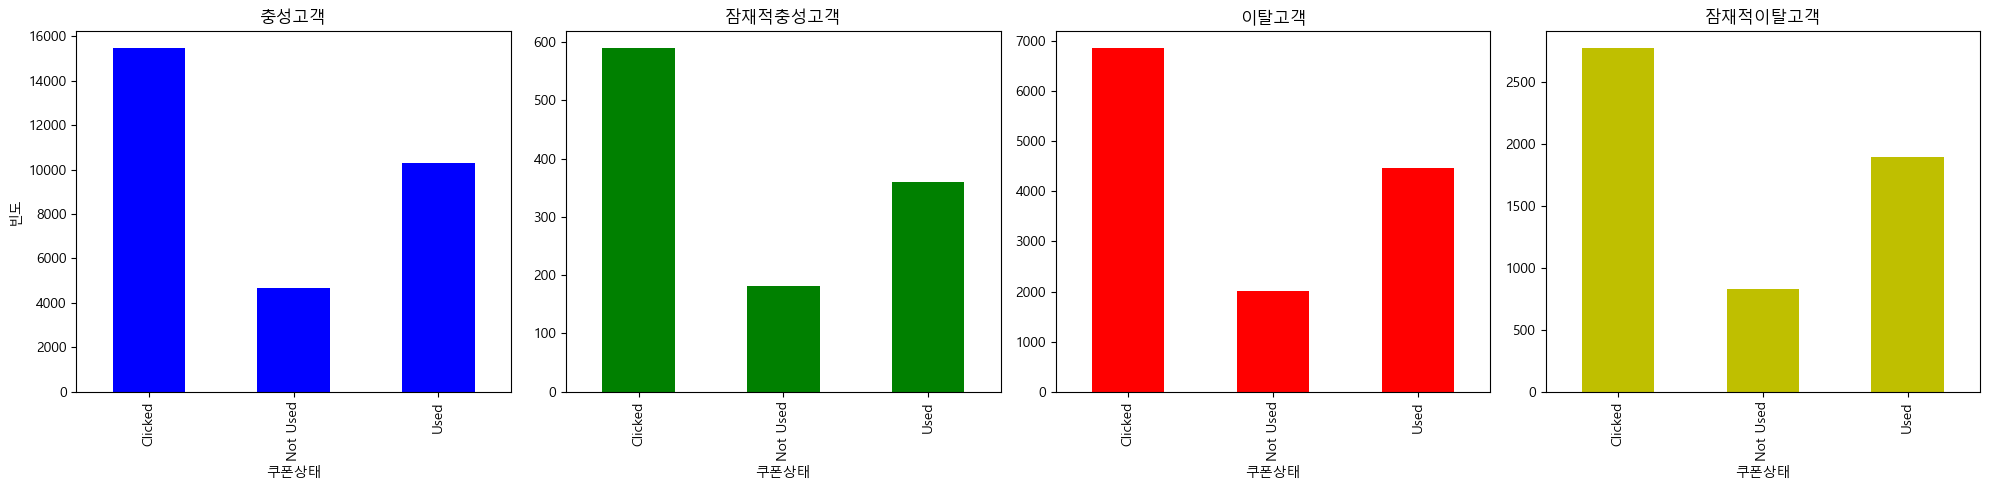

In [97]:
import matplotlib.pyplot as plt

# 서브플롯 생성
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=False)

# 각 서브플롯에 바 그래프 그리기
certainty_in_customer['쿠폰상태'].value_counts().sort_index().plot(kind='bar', ax=axs[0], color='b')
potential_in_customer['쿠폰상태'].value_counts().sort_index().plot(kind='bar', ax=axs[3], color='y')
certainty_out_customer['쿠폰상태'].value_counts().sort_index().plot(kind='bar', ax=axs[1], color='g')
potential_out_customer['쿠폰상태'].value_counts().sort_index().plot(kind='bar', ax=axs[2], color='r')

# 각 서브플롯에 제목 추가
axs[0].set_title('충성고객')
axs[1].set_title('잠재적충성고객')
axs[2].set_title('이탈고객')
axs[3].set_title('잠재적이탈고객')

# x축 레이블 추가
for ax in axs:
    ax.set_xlabel('쿠폰상태')

# y축 레이블 추가
axs[0].set_ylabel('빈도')
plt.tight_layout()

# 그래프 보여주기
plt.show()
